### Final Report: Machine Learning and Neural Networks - Deep Learning on a public dataset

# Project title: A Comparative Analysis of Publisher-Curated vs. User-Generated Recipe Success Factors

## Table of Contents

1. [Introduction and Project Setup](#1-introduction-and-project-setup)<br>
1.1 [Setup and Data Loading](#11-setup-and-data-loading)<br>
2. [Dataset Exploration](#2-dataset-exploration)<br>
2.1 [Basic Inspection of the Dataset](#21-basic-inspection-of-the-dataset)<br>
2.2 [Data Cleaning and Exploration of Publisher and Community Data](#22-data-cleaning-and-exploration-of-publisher-and-community-data)<br>
3. [Data Preparation](#3-data-preparation)<br>
3.1 [Handle Outliers](#31-handle-outliers)<br>
3.2 [Handle Missing Values](#32-handle-missing-values)<br>
3.3 [Handle Text Data](#33-handle-text-data)<br>
4. [Feature Importance and Selection](#4-feature-importance-and-selection)<br>
4.1 [Key popularity factors](#41-key-popularity-factors)<br>
4.2 [Key popularity factors per recipe type](#42-key-popularity-factors-per-recipe-type)<br>
5. [Baseline Model Training and Evaluation](#5-baseline-model-training-and-evaluation)<br>
6. [Neural Networks](#6-neural-networks)<br>
6.1 [Simple Neural Networks](#61-simple-neural-networks)<br>
6.2 [Deep Neural Networks](#62-deep-neural-networks)<br>
6.3 [Transformer-Based Neural Network](#63-transformer-based-neural-network)<br>
7. [Summary and comparison](#7-summary-and-comparison)<br>
7.1 [Predict on unseen data](#61-predict-on-unseen-data)<br>
8. [Conclusions](#8-conclusions)

# 1. Introduction and Project setup

This project explores the culinary landscape, where professionally curated recipes by chefs and food bloggers intersect with a growing body of user-generated content. The study utilizes Machine Learning and Deep Learning techniques on a comprehensive dataset from Tasty to identify the **key factors that contribute to recipe popularity**. By comparing these success factors between **recipes crafted by professionals and those created by everyday cooking enthusiasts**, the project aims to provide valuable insights that can inform content strategies for food publishers and empower individual creators in the digital age.

## 1.1 Setup and Data Loading

In [55]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing and NLP
import re
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning Models and Evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Deep Learning and Transformers
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Utility and I/O
import os
import joblib
from scipy.sparse import hstack
import pickle

import warnings
warnings.filterwarnings("ignore")

In [56]:
# Load data
df_recipes = pd.read_csv('Data/tasty_recipes.csv')
df_recipes.head()

,Recipe Title,Author,Role,Score,Total Time,Prep Time,Cook Time,Ingredients,Preparation Steps,Calories,Fat,Carbs,Fiber,Sugar,Protein,Tags,Recipe URL
0,Roasted Moroccan Carrots With Baba Ganoush,Fiona Anchal,Community Member,NaN,30 minutes,10 minutes,20 minutes,"['1 bunch dutch carrots, washed and tops trimm...",['Place carrots on a baking dish lined with ba...,72.0,4 g,8 g,2 g,2 g,2 g,"['Meal', 'Dinner', 'Weeknight', 'Kosher', 'Hal...",https://tasty.co/recipe/roasted-moroccan-carro...
1,Edamame Truffle Dumplings In Miso Broth,Nimisha Wasankar,Community Member,NaN,1 hr 10 min,40 minutes,30 minutes,"['1 package frozen shelled edamame', '2 tables...",['Cook the frozen edamame according the packag...,413.0,16 g,49 g,6 g,3 g,18 g,"['Cuisine', 'Asian', 'Japanese', 'Soy', 'Glute...",https://tasty.co/recipe/edamame-truffle-dumpli...
2,Grilled Napa Cabbage Fattoush Salad,Reza Setayesh,Community Member,NaN,40 minutes,20 minutes,20 minutes,"['1 head medium napa cabbage', '1 small red on...",['Preheat the grill and preheat the oven to 37...,430.0,29 g,32 g,2 g,6 g,9 g,"['Cuisine', 'European', 'Mediterranean', 'Kosh...",https://tasty.co/recipe/grilled-napa-cabbage-f...
3,Roasted Tomato Basil Soup,Merle O'Neal,Tasty Team,91% would make again,25 minutes,5 minutes,20 minutes,"['1 tablespoon olive oil', '1 yellow onion, di...","['In a large pot over medium heat, combine the...",48.0,0 g,9 g,1 g,2 g,1 g,"['Meal', 'Dinner', 'Soups', 'Budget', 'High-Fi...",https://tasty.co/recipe/roasted-tomato-basil-soup
4,Tuna Salad With Roasted Veggies,Mercedes Sandoval,Tasty Team,96% would make again,35 minutes,15 minutes,20 minutes,"['1 cup green beans (360 g), trimmed', '2 cups...","['Preheat the oven to 375˚F (190˚C).', 'On a b...",576.0,19 g,51 g,7 g,11 g,49 g,"['Meal', 'Lunch', 'Salads', 'Dairy', 'Fish', '...",https://tasty.co/recipe/tuna-salad-with-roaste...


The dataset contains information about various recipes, including attributes such as recipe score, keywords, cooking times, and nutritional values.

# 2. Dataset Exploration

## 2.1 Basic Inspection of the Dataset

In [57]:
print("Basic Information:")
print(df_recipes.info())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6604 entries, 0 to 6603
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Recipe Title       6604 non-null   object 
 1   Author             5945 non-null   object 
 2   Role               5500 non-null   object 
 3   Score              5144 non-null   object 
 4   Total Time         5397 non-null   object 
 5   Prep Time          5408 non-null   object 
 6   Cook Time          5408 non-null   object 
 7   Ingredients        6604 non-null   object 
 8   Preparation Steps  6604 non-null   object 
 9   Calories           5982 non-null   float64
 10  Fat                5982 non-null   object 
 11  Carbs              5982 non-null   object 
 12  Fiber              5982 non-null   object 
 13  Sugar              5982 non-null   object 
 14  Protein            5982 non-null   object 
 15  Tags               6604 non-null   object 
 16  Recip

Overall, the dataset is in good shape and offers strong potential for analysis after addressing minor issues like missing values and data type conversions. Given the missing values in columns, applying imputation strategies will be necessary, especially before any modeling efforts.

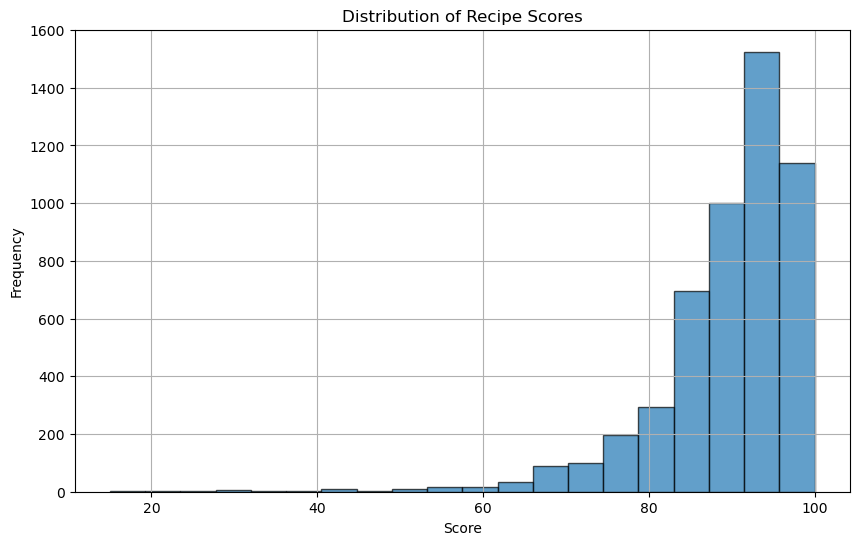

In [58]:
# Clean the Score column to extract only the numerical values
df_recipes['Score'] = df_recipes['Score'].str.extract(r'(\d+)%')[0].astype(float)

# Plot the distribution of the scores
plt.figure(figsize=(10, 6))
plt.hist(df_recipes['Score'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Recipe Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The ratings of recipes tend to be rather on the positive side for throughout the dataset.

In [59]:
# Transform the Role column
role_mapping = {
    'Tasty Team': 0,
    'Community Member': 1,
    None: 2
}
df_recipes['Role'] = df_recipes['Role'].map(lambda x: role_mapping.get(x, 2))

# Get the count of each role, including NaN values separately
role_counts = df_recipes['Role'].value_counts(dropna=False)
# Print the exact counts
print("Role Counts: ")
print(role_counts)

# Filter out NaN roles
filtered_df = df_recipes[df_recipes['Role'] != 2]

# Get the count of each role, excluding NaN values
role_counts_filtered = filtered_df['Role'].value_counts()

Role Counts: 
Role
0    4764
2    1104
1     736
Name: count, dtype: int64


To address the recipes with an unassigned role (either "Community" or "Publisher"), it's essential to investigate these entries by examining the associated **author of each recipe**. This inspection can help identify patterns or potential correlations between the author and the missing role designation, possibly leading to more informed decisions on how to assign these roles.

In [60]:
# Identify recipes with Role = 2
role_2_recipes = df_recipes[df_recipes['Role'] == 2]

# Print unique authors for recipes with Role = 2
unique_authors_with_role_2 = role_2_recipes['Author'].dropna().unique()
print("Unique Authors with Role = 2:")
print(unique_authors_with_role_2)

Unique Authors with Role = 2:
['Kroger' 'Visit Florida' 'Walmart' 'Prego' "Hellmann's" 'KraftHeinz'
 'Lipton' "Bush's Beans" 'VisitSingapore' 'Easter Sunday'
 'Starbucks Frappuccino' 'Newell Ball' 'McCormick' 'Guinness' 'Planet Oat'
 'Intuit TurboTax Live' 'LALA' "Campbell's" "Frank's RedHot" 'Pace'
 'Cabot Creamery Co-operative' 'Bumble Bee Tuna' 'Ore-Ida'
 'Amazon Prime Fresh' 'Pepsi' 'The Little Potato Company' 'Geico'
 'Tanqueray' 'SpongeTowels' 'Pillsbury' 'Heluva Good' 'Crown Royal'
 'Castle Wood Reserve' 'Napoleon' 'Captain Morgan' 'Bulleit'
 'Charter Reserve' "Welch's" 'McCain Foods' 'DoorDash' "Justin's"
 'Snyder’s of Hanover®' 'Albertsons' 'Cholula' 'Stella Rosa® Wines'
 'Grill Mates' 'Sabra' 'Deep Indian Kitchen' 'Sun-Bird' 'Juicy Juice'
 'Next Level Chef on Fox' 'Birds Eye' "French's" 'Kerrygold' 'Modelo'
 'Impossible™ Foods' 'Chase' 'Pure Leaf' 'Mezzetta' 'Biden For President'
 "BJ's Wholesale" 'Palmolive' 'Signature Select' 'Incredible Egg'
 'Country Crock® Plant Based an

Those recipes can be identified as published by official partners and will belong to non-community recipes. Assigning these roles correctly ensures better organization and more accurate categorization within the dataset.

In [61]:
# Update Role = 2 to Role = 0 for partner recipes with identified authors
for author in unique_authors_with_role_2:
    matching_recipes = df_recipes.loc[(df_recipes['Author'] == author) & (df_recipes['Role'] == 2)]
    df_recipes.loc[(df_recipes['Author'] == author) & (df_recipes['Role'] == 2), 'Role'] = 0

# Get the count of each role after the update
role_counts_after = df_recipes['Role'].value_counts()

# Print the exact counts after the update
print("Role Counts after updating specific Role = 2 to Role = 0:")
print(role_counts_after)

Role Counts after updating specific Role = 2 to Role = 0:
Role
0    5209
1     736
2     659
Name: count, dtype: int64


After reclassifying recipes as non-community (Role = 0), 659 recipes still remain with unassigned roles (Role = 2). While these entries may not be ideal for training models due to their incomplete categorization, they can still be valuable for imputing missing values within the dataset.

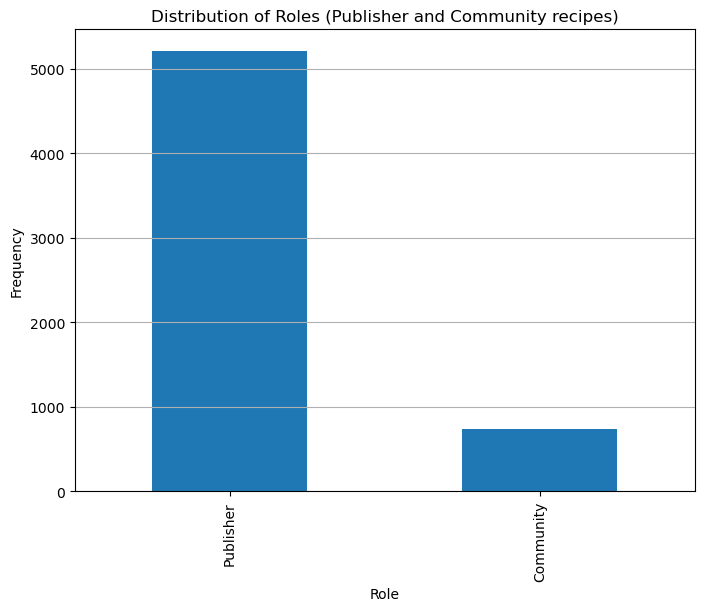

In [62]:
# Filter out NaN roles for plotting
filtered_df_after = df_recipes[df_recipes['Role'] != 2]

# Get the count of each role, excluding NaN values
role_counts_filtered_after = filtered_df_after['Role'].value_counts()

# Plot the distribution of the Role column excluding NaN
plt.figure(figsize=(8, 6))
role_counts_filtered_after.plot(kind='bar')
plt.title('Distribution of Roles (Publisher and Community recipes)')
plt.xlabel('Role')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Publisher', 'Community'])
plt.grid(axis='y')
plt.show()

### Learnings from basic data exploration

1. **Imbalance in Data**:
   - The number of publisher recipes is significantly higher than the number of community recipes. This indicates an imbalance in the dataset.

2. **Publisher Recipes**:
   - These are likely to be more standardized, possibly following specific guidelines and quality checks.
   - They may have more consistent and complete data, making them potentially more reliable for training models.

3. **Community Recipes**:
   - These recipes might exhibit more variability in style, ingredients, and instructions, reflecting a wider range of cooking practices and preferences.
   - They could provide valuable diversity to the dataset, capturing a broader spectrum of culinary creativity.

4. **Separate Analysis**:
   - Given the disparity, it will be useful to analyze publisher and community recipes separately to understand unique patterns and features within each group.

6. **Feature Importance**:
   - Analyzing feature importance separately for each group might uncover different driving factors for each type of recipe, aiding in more tailored recommendations and insights.

## 2.2 Data Cleaning and Exploration of Publisher and Community Data

To better understand the distinctions between community and publisher recipes, the next step involves data cleaning and preprocessing. This will include addressing any inconsistencies, handling missing values, and preparing the dataset for further analysis, along with visual data exploration to uncover patterns, relationships, and potential differences between community and publisher recipes.

In [63]:
# Function to convert time strings to minutes
def convert_to_minutes(time_str):
    if pd.isna(time_str):
        return None
    time_str = time_str.lower()
    minutes = 0
    if 'hr' in time_str:
        hours = re.search(r'(\d+)\s*hr', time_str)
        if hours:
            minutes += int(hours.group(1)) * 60
    if 'min' in time_str:
        mins = re.search(r'(\d+)\s*min', time_str)
        if mins:
            minutes += int(mins.group(1))
    elif 'minute' in time_str:
        mins = re.search(r'(\d+)\s*minute', time_str)
        if mins:
            minutes += int(mins.group(1))
    return minutes

# Apply the function to transform cooking times to floats
df_recipes['Total Time'] = df_recipes['Total Time'].apply(convert_to_minutes)
df_recipes['Prep Time'] = df_recipes['Prep Time'].apply(convert_to_minutes)
df_recipes['Cook Time'] = df_recipes['Cook Time'].apply(convert_to_minutes)

In [64]:
# Function to remove 'g' from nutritional values and convert to floats
def remove_g(value):
    if pd.isna(value):
        return None
    return float(value.replace('g', '').strip())

# Apply the function to nutritional data columns
df_recipes['Fat'] = df_recipes['Fat'].apply(lambda x: remove_g(str(x)))
df_recipes['Carbs'] = df_recipes['Carbs'].apply(lambda x: remove_g(str(x)))
df_recipes['Fiber'] = df_recipes['Fiber'].apply(lambda x: remove_g(str(x)))
df_recipes['Sugar'] = df_recipes['Sugar'].apply(lambda x: remove_g(str(x)))
df_recipes['Protein'] = df_recipes['Protein'].apply(lambda x: remove_g(str(x)))

In [65]:
# Split the data into Publisher and Community Member
publisher_recipes = df_recipes[df_recipes['Role'] == 0]
community_recipes = df_recipes[df_recipes['Role'] == 1]

# Basic statistics for each group
print("Basic Statistics for Publisher Recipes:")
print(publisher_recipes.describe())

print("\nBasic Statistics for Community Member Recipes:")
print(community_recipes.describe())

Basic Statistics for Publisher Recipes:
         Role        Score   Total Time    Prep Time    Cook Time  \
count  5209.0  4420.000000  4145.000000  4156.000000  4156.000000   
mean      0.0    89.192081    98.363329    32.418191    42.500722   
std       0.0     8.852567   137.547367    59.599133    70.102752   
min       0.0    15.000000     1.000000     1.000000     1.000000   
25%       0.0    86.000000    35.000000    15.000000    15.000000   
50%       0.0    92.000000    55.000000    20.000000    25.000000   
75%       0.0    95.000000   100.000000    30.000000    45.000000   
max       0.0   100.000000  1410.000000  1060.000000  1425.000000   

          Calories          Fat        Carbs        Fiber        Sugar  \
count  4695.000000  4695.000000  4695.000000  4695.000000  4695.000000   
mean    453.541001    21.358466    46.237274     4.010437    17.656230   
std     299.812477    18.748440    36.861334     5.393120    19.301595   
min       0.000000     0.000000     0.0000

**Publisher Recipes**:
  - These recipes have a higher average score (89.2) and a broad range of total cooking times, averaging 98.36 minutes. The nutritional values show a moderate calorie content (453.54 kcal on average) with a balanced mix of fats, carbs, and proteins.
  - The large standard deviations suggest significant diversity in recipe complexity and nutritional profiles.

**Community Member Recipes**:
  - Community recipes feature slightly lower average scores (87.6) and shorter total times (71.39 minutes). The nutritional profile is similar but slightly lighter, with a lower average calorie count (424.09 kcal).
  - The more uniform distribution suggests less variation, indicating generally simpler and quicker recipes.

These insights indicate that publisher recipes are more diverse and potentially more complex, whereas community recipes tend to be simpler and quicker to prepare. The slightly lower scores of community recipes may reflect their relative simplicity.

In [66]:
# Basic Information
print("Basic information for Publisher Recipes:")
print(publisher_recipes.info())

print("\nBasic information for Community Member Recipes:")
print(community_recipes.info())

Basic information for Publisher Recipes:
<class 'pandas.core.frame.DataFrame'>
Index: 5209 entries, 3 to 6603
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Recipe Title       5209 non-null   object 
 1   Author             5209 non-null   object 
 2   Role               5209 non-null   int64  
 3   Score              4420 non-null   float64
 4   Total Time         4145 non-null   float64
 5   Prep Time          4156 non-null   float64
 6   Cook Time          4156 non-null   float64
 7   Ingredients        5209 non-null   object 
 8   Preparation Steps  5209 non-null   object 
 9   Calories           4695 non-null   float64
 10  Fat                4695 non-null   float64
 11  Carbs              4695 non-null   float64
 12  Fiber              4695 non-null   float64
 13  Sugar              4695 non-null   float64
 14  Protein            4695 non-null   float64
 15  Tags               5209 non-null   o

After splitting between Publisher and Community recipes, it is evident that some fields (eg. 'Score'), particularly for community recipes, are sparse and will require imputation or special handling during analysis.

A further visual exploration of the features in the dataset will provide insights into the differences between the two recipe types.

### Recipe scores

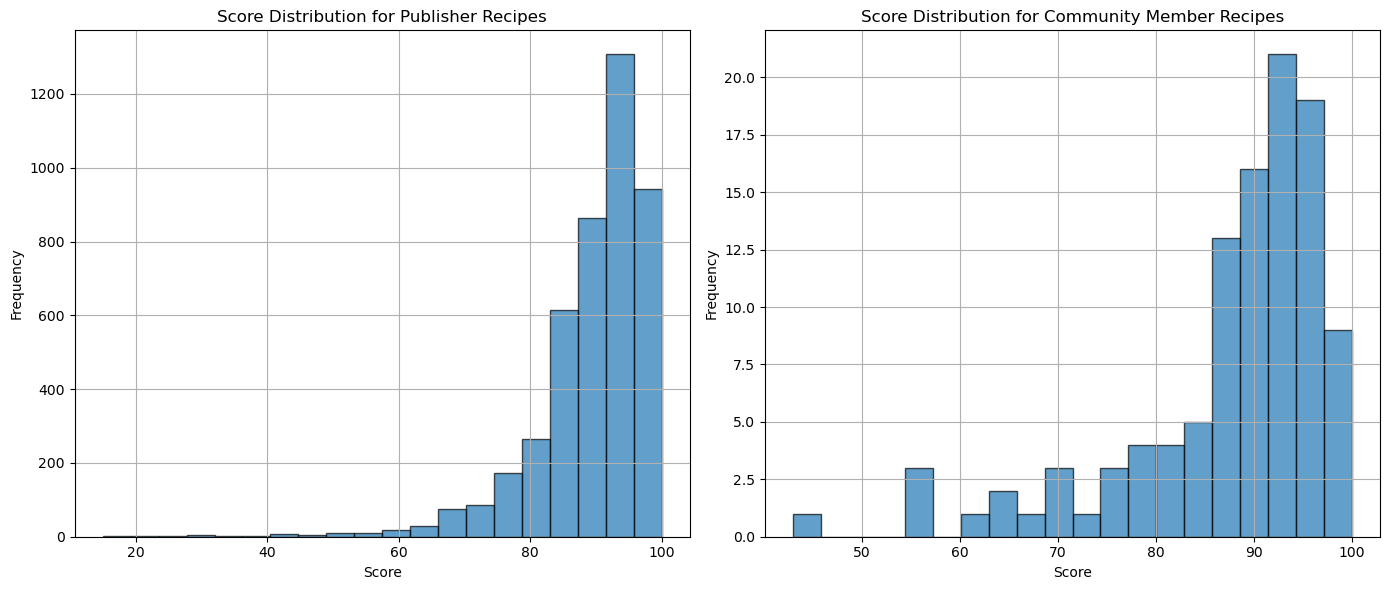

In [67]:
# Score distribution for each group
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(publisher_recipes['Score'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Score Distribution for Publisher Recipes')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(community_recipes['Score'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Score Distribution for Community Member Recipes')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

**Publisher Recipes:** The scores show a concentrated distribution, with most scores falling between 85 and 100. The mean score is now approximately 89, with a tighter spread, indicating that publisher recipes generally maintain a consistently high standard. The histogram supports this, showing a clear peak near the upper range of the scores.

**Community Member Recipes:** The scores are more spread out, with a significant number of high scores close to 100. The mean score is slightly lower at about 87.6, and the distribution is broader compared to publisher recipes, suggesting more variability in quality among community contributions.

Both groups display a high frequency of recipes with scores in the upper range, reflecting overall quality, with publisher recipes being slightly more consistent in achieving higher scores.

### Cooking times

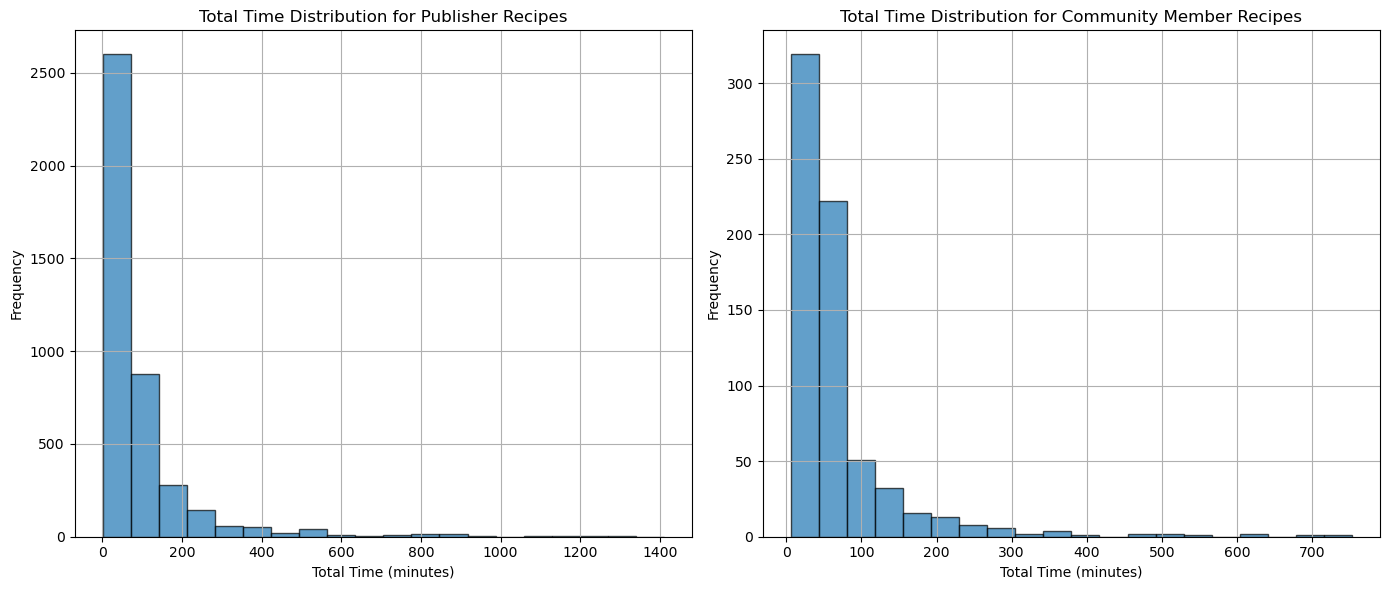

In [68]:
# Plot total time distribution for each group
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(publisher_recipes['Total Time'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Total Time Distribution for Publisher Recipes')
plt.xlabel('Total Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(community_recipes['Total Time'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Total Time Distribution for Community Member Recipes')
plt.xlabel('Total Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

**Publisher Recipes:** The total cooking time distribution still skews left, with most recipes under 200 minutes and a strong peak below 100 minutes. However, the range now extends up to 1400 minutes, reflecting a diverse range of recipes.

**Community Member Recipes:** The total time distribution is similar to that of publisher recipes, though with fewer extreme outliers and a maximum time of around 700 minutes. This suggests simpler and quicker recipes compared to those from publishers.

Overall, publisher recipes show a wider range of complexity and cooking time, while community recipes tend to be more consistent and quicker to prepare.

### Nutritional values

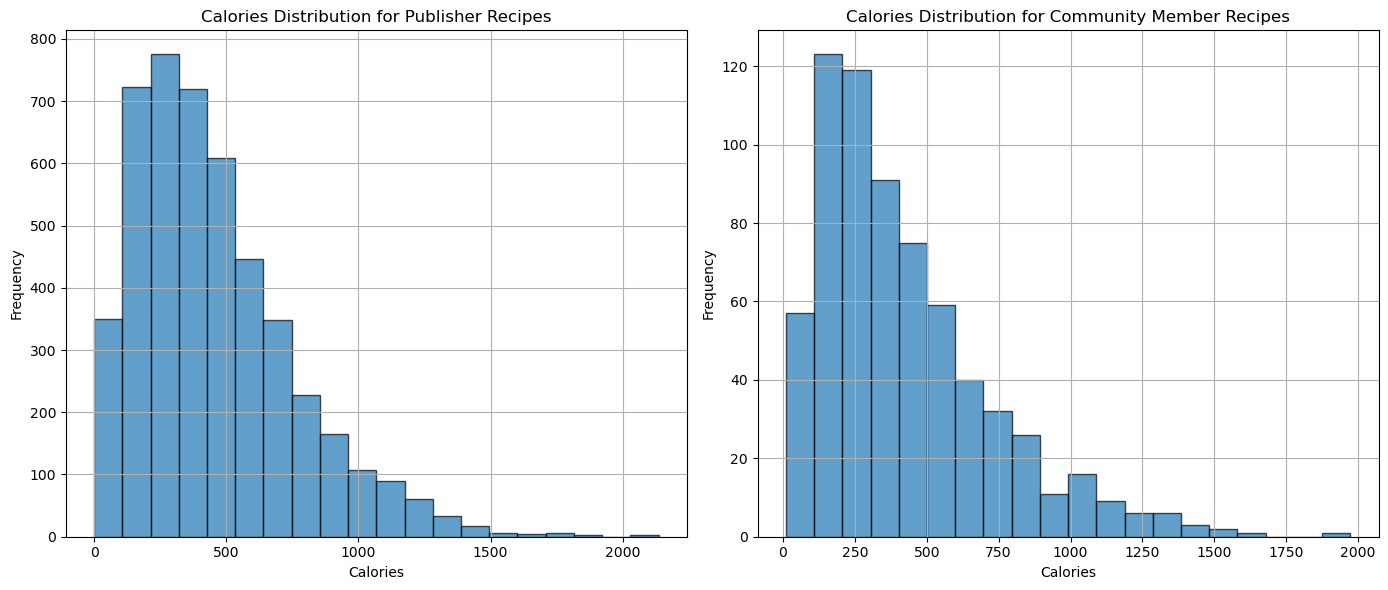

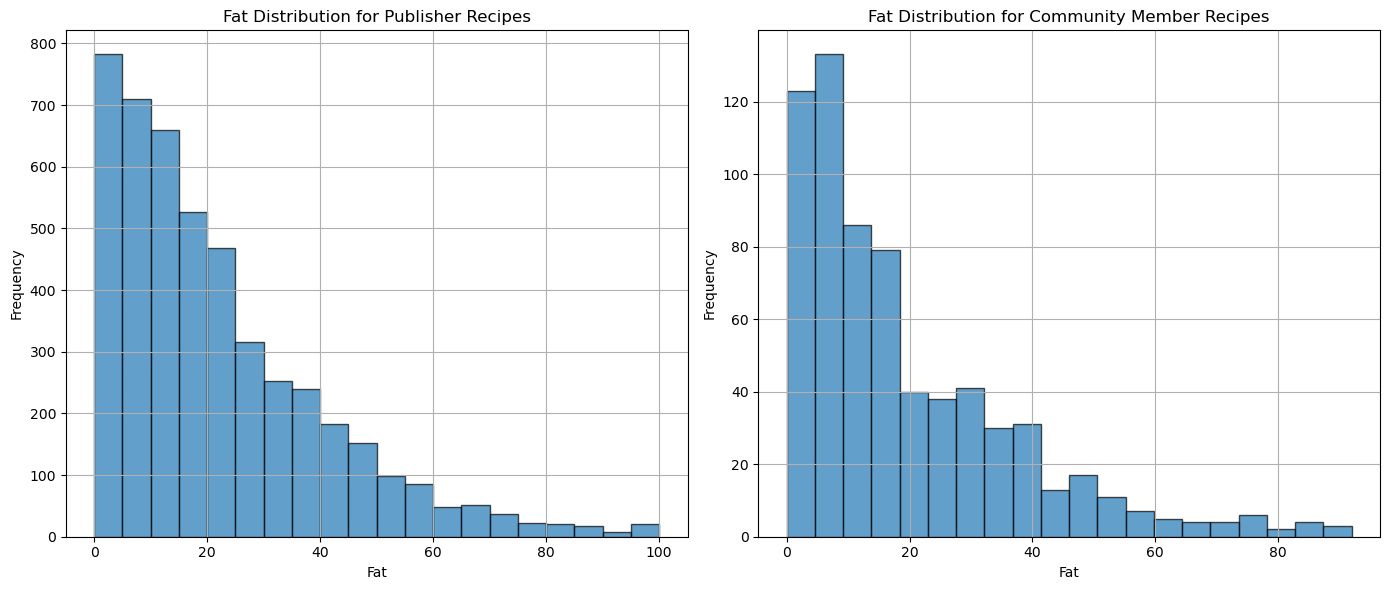

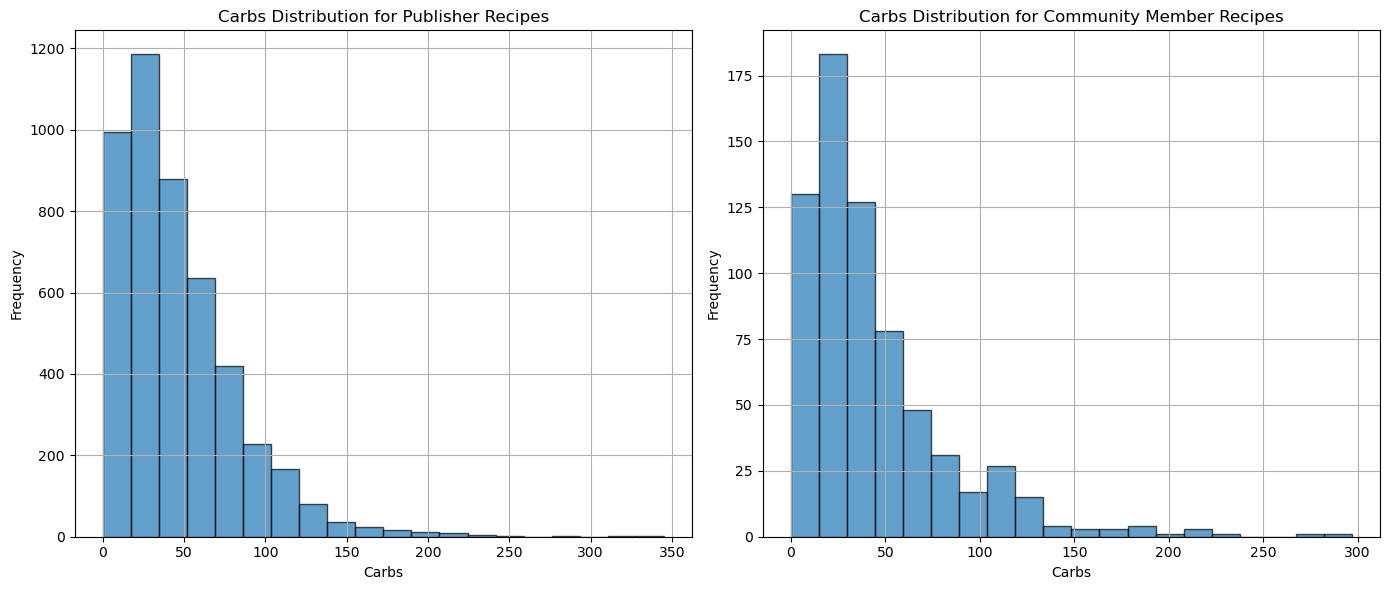

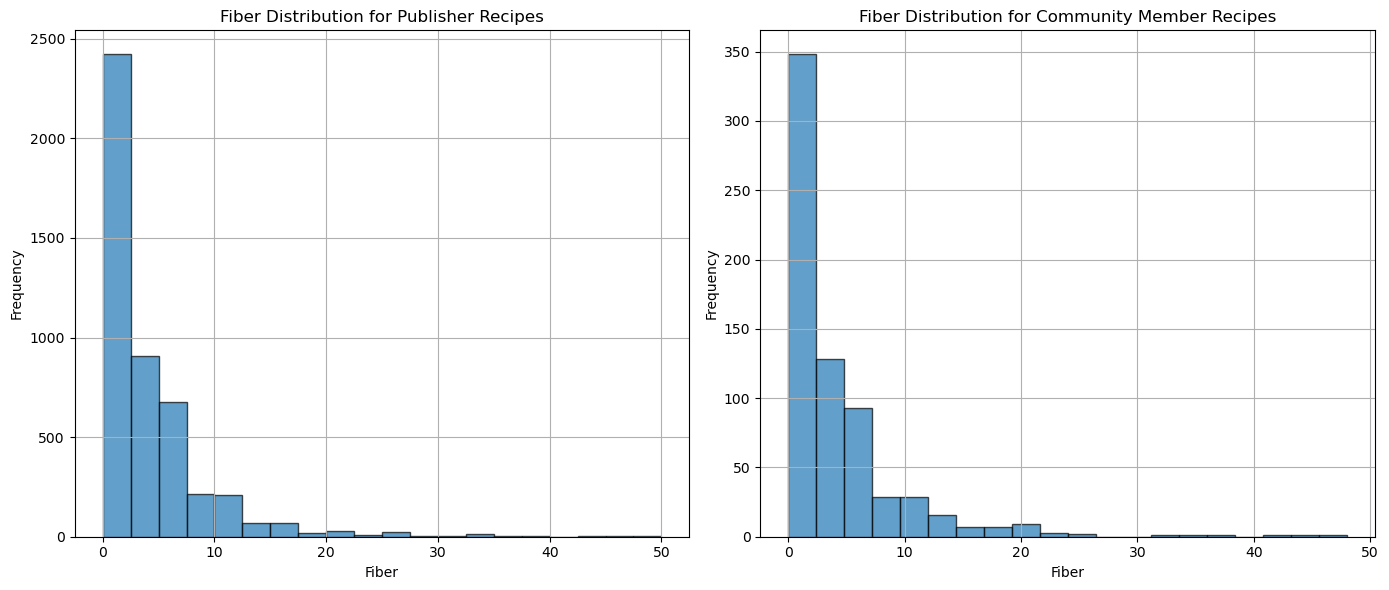

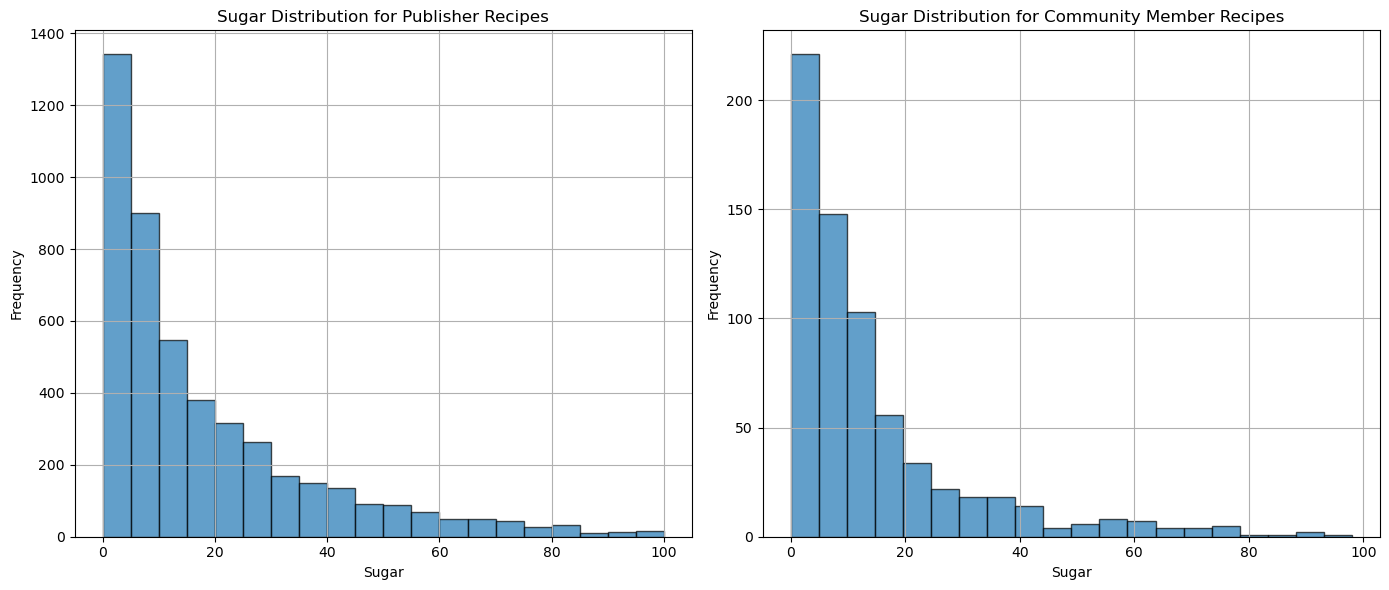

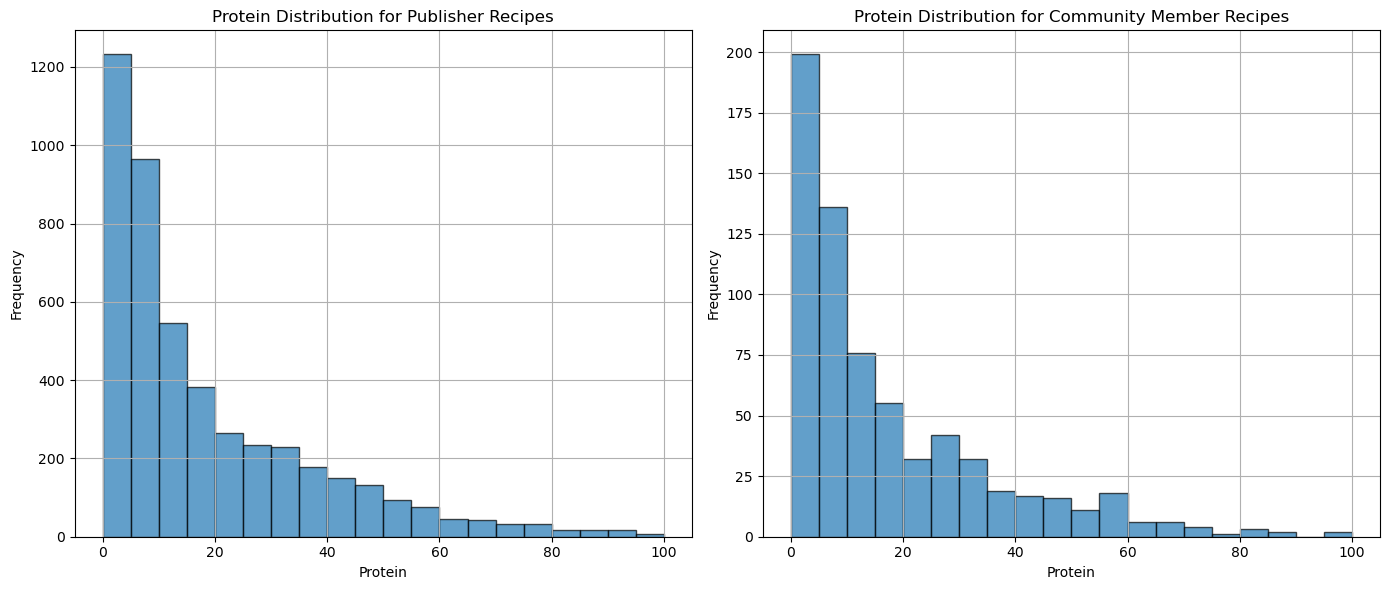

In [69]:
# Nutritional data distribution for each group
nutritional_columns = ['Calories', 'Fat', 'Carbs', 'Fiber', 'Sugar', 'Protein']
for col in nutritional_columns:
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.hist(publisher_recipes[col].dropna(), bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'{col} Distribution for Publisher Recipes')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(community_recipes[col].dropna(), bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'{col} Distribution for Community Member Recipes')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

- **Calories**: Publisher recipes tend to have a broader distribution with a peak around 300-600 calories, while community recipes generally have lower calorie counts, with a peak around 200-400 calories.
- **Fat**: Similar to calories, publisher recipes show a wider range of fat content, while community recipes have a tighter distribution.
- **Carbs**: Both types show a right-skewed distribution, but publisher recipes again have a wider range.
- **Fiber**: Most recipes, in both groups, contain low fiber content, with a steep drop-off after 10g.
- **Sugar**: Publisher recipes tend to have more sugar content, but both groups have a peak around 5-10g.
- **Protein**: Publisher recipes generally have higher protein content, with a broader distribution, while community recipes tend to be concentrated around 10-30g.

Overall, publisher recipes show more diversity in nutritional values, suggesting a broader range of ingredients and preparation methods. Community recipes are more consistent and generally lower in these nutritional values.

### Popular ingredients

In [70]:
# List of common spices and ingredients to exclude, eg. those that can be found in most of the recipes
exclude_patterns = [
    r'salt', r'pepper', r'olive oil', r'water', r'sugar', r'garlic',
    r'onion', r'butter', r'oil', r'vanilla', r'spray', r'soy',
    r'baking soda', r'flour', r'milk', r'egg', r'eggs', r'paprika', r'juice', r'powder', r'seeds', r'oregano', r'cornstarch', r'leaves'
]

In [71]:
# Function to normalize ingredient names by removing amounts and units
def normalize_ingredient(ingredient):
    # Remove common fractions
    ingredient = re.sub(r'\b(½|¼|¾|⅓|⅔)\b', '', ingredient)
    # Remove standalone numbers and fractions
    ingredient = re.sub(r'\d+\s*/\s*\d+', '', ingredient)  # Remove fractions
    ingredient = re.sub(r'\d+', '', ingredient)  # Remove standalone numbers
    # Remove units
    ingredient = re.sub(r'\b(cup|cups|tablespoon|tablespoons|teaspoon|teaspoons|oz|ounce|ounces|lb|pound|pounds|g|grams|kg|kilograms|ml|milliliters|liter|liters)\b', '', ingredient, flags=re.IGNORECASE)
    # Remove text in parentheses
    ingredient = re.sub(r'\([^)]*\)', '', ingredient)
    # Remove punctuation
    ingredient = re.sub(r'[^\w\s]', '', ingredient)
    # Remove extra whitespace
    ingredient = ' '.join(ingredient.split())
    ingredient = ingredient.strip().lower()
    return ingredient

In [72]:
# Function to process ingredient lists and count frequency of each ingredient
def count_ingredients(recipes, exclude_patterns):
    all_ingredients = []
    for ingredients_list in recipes['Ingredients'].dropna():
        ingredients = eval(ingredients_list)  # Convert string representation of list to actual list
        normalized_ingredients = [normalize_ingredient(ingredient) for ingredient in ingredients]
        filtered_ingredients = [ingredient for ingredient in normalized_ingredients if not any(re.search(pattern, ingredient) for pattern in exclude_patterns)]
        all_ingredients.extend(filtered_ingredients)
    return Counter(all_ingredients)

In [73]:
# Count ingredients for each group
publisher_ingredients_count = count_ingredients(publisher_recipes, exclude_patterns)
community_ingredients_count = count_ingredients(community_recipes, exclude_patterns)

# Get the most common ingredients
most_common_publisher_ingredients = publisher_ingredients_count.most_common(20)
most_common_community_ingredients = community_ingredients_count.most_common(20)

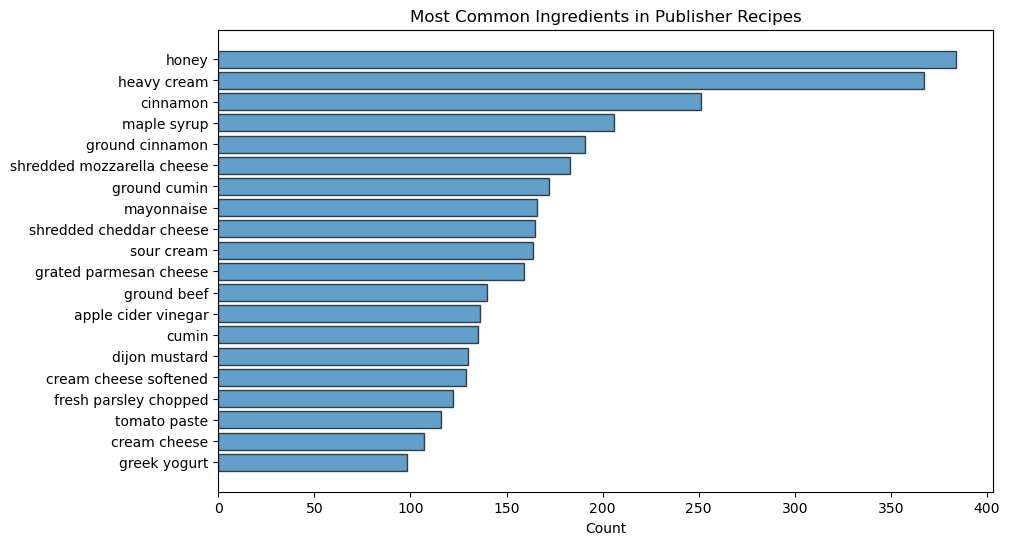

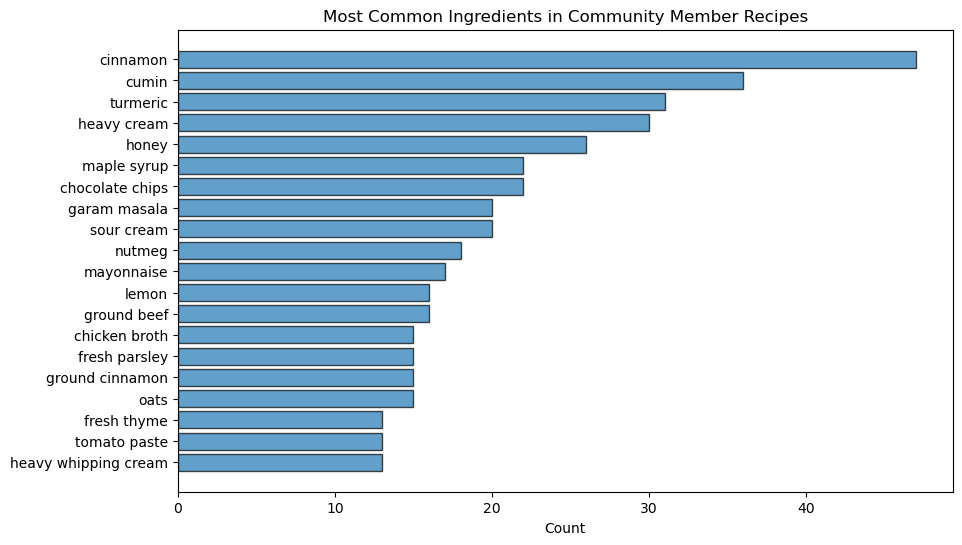

In [74]:
# Plot the most common ingredients for each group
def plot_common_ingredients(common_ingredients, title):
    ingredients, counts = zip(*common_ingredients)
    plt.figure(figsize=(10, 6))
    plt.barh(ingredients, counts, edgecolor='k', alpha=0.7)
    plt.xlabel('Count')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Plot the most common ingredients for Publisher and Community Member recipes
plot_common_ingredients(most_common_publisher_ingredients, 'Most Common Ingredients in Publisher Recipes')
plot_common_ingredients(most_common_community_ingredients, 'Most Common Ingredients in Community Member Recipes')

**Publisher Recipes**:
  - **Diverse and Rich Ingredients**: The most frequent ingredients include honey, heavy cream, cinnamon, and a variety of cheeses such as mozzarella and cheddar. These selections indicate a focus on rich and comforting dishes, appealing to a broad audience.
  - **Wide Flavor Range**: The usage of ingredients like sour cream, cumin, and Dijon mustard points to a diverse range of flavors, from creamy to spicy, suggesting these recipes cater to varied tastes.

**Community Member Recipes**:
  - **Spice and Flavor-Focused**: Ingredients like cinnamon, cumin, turmeric, and heavy cream are common, showcasing a preference for bold, traditional flavors. Chocolate chips and honey also suggest a blend of sweet and rich culinary creations.
  - **Diverse Culinary Influences**: The presence of ingredients such as garam masala and fresh parsley highlights the varied influences and personal creativity evident in these recipes.

These observations suggest that publisher recipes emphasize universally appealing, rich flavors, while community member recipes feature a mix of traditional spices and personalized touches.

### Number of steps and ingredients

In [75]:
# Function to count the number of steps in the preparation steps
def count_steps(preparation_steps):
    try:
        steps = eval(preparation_steps)
        return len(steps)
    except:
        return 0

# Function to count the number of ingredients
def count_ingredients(ingredients):
    try:
        ingredients_list = eval(ingredients)
        return len(ingredients_list)
    except:
        return 0

In [76]:
# Add new columns for the number of steps and the number of ingredients
df_recipes['Number of Steps'] = df_recipes['Preparation Steps'].apply(count_steps)
df_recipes['Number of Ingredients'] = df_recipes['Ingredients'].apply(count_ingredients)

# Split the data into Publisher and Community Member recipes
publisher_recipes = df_recipes[df_recipes['Role'] == 0]
community_recipes = df_recipes[df_recipes['Role'] == 1]

# Calculate basic statistics for the number of steps and number of ingredients
publisher_stats = publisher_recipes[['Number of Steps', 'Number of Ingredients']].describe()
community_stats = community_recipes[['Number of Steps', 'Number of Ingredients']].describe()

# Print the statistics
print("Publisher Recipes Statistics:")
print(publisher_stats)
print("\nCommunity Member Recipes Statistics:")
print(community_stats)

Publisher Recipes Statistics:
       Number of Steps  Number of Ingredients
count      5209.000000            5209.000000
mean          9.554041              11.815128
std           3.878756               6.178368
min           2.000000               1.000000
25%           7.000000               7.000000
50%           9.000000              11.000000
75%          12.000000              15.000000
max          36.000000              61.000000

Community Member Recipes Statistics:
       Number of Steps  Number of Ingredients
count       736.000000             736.000000
mean          7.826087              11.355978
std           3.064774               5.133157
min           3.000000               2.000000
25%           6.000000               8.000000
50%           7.000000              11.000000
75%           9.000000              14.000000
max          25.000000              36.000000


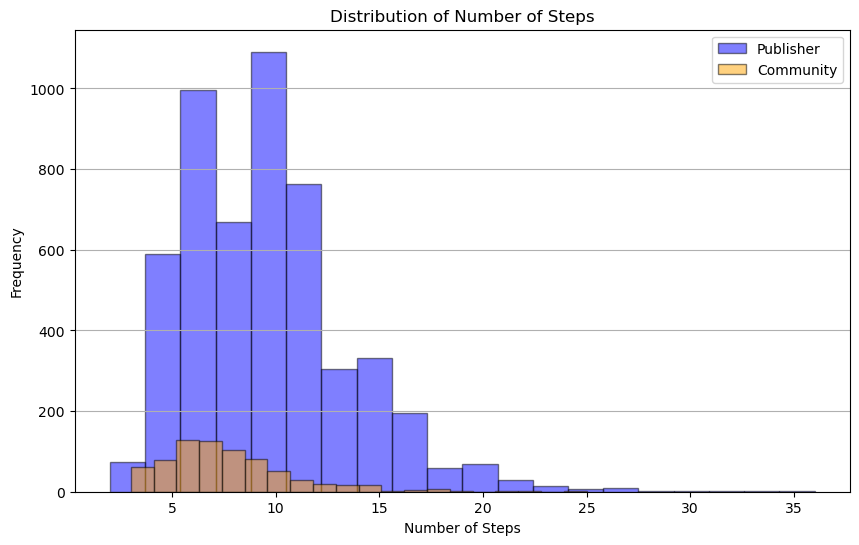

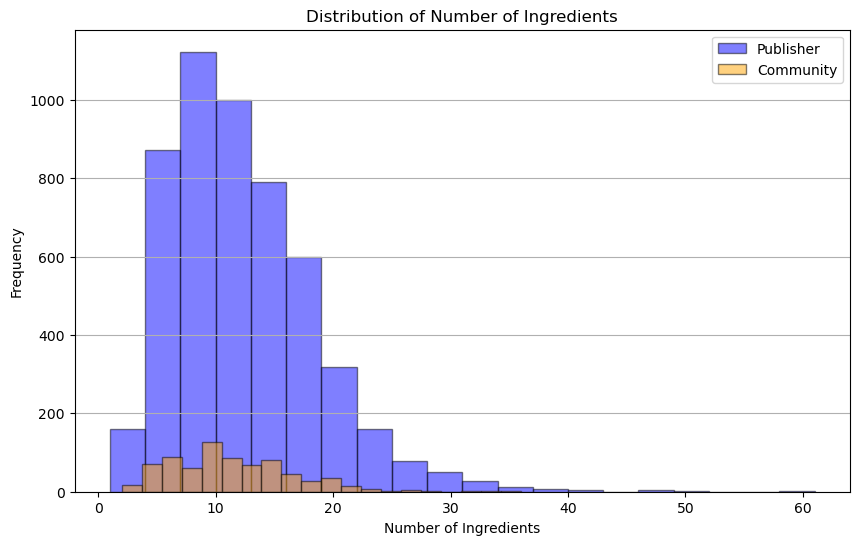

In [77]:
def plot_distribution(data, column, title):
    plt.figure(figsize=(10, 6))
    plt.hist(data[column], bins=20, alpha=0.5, label='Publisher', color='blue', edgecolor='black')
    plt.hist(community_recipes[column], bins=20, alpha=0.5, label='Community', color='orange', edgecolor='black')
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# Plot distributions
plot_distribution(publisher_recipes, 'Number of Steps', 'Distribution of Number of Steps')
plot_distribution(publisher_recipes, 'Number of Ingredients', 'Distribution of Number of Ingredients')

**Distribution of Number of Steps**:
   - Publisher recipes show a broader distribution with a higher peak at around 8-10 steps.
   - Community member recipes have a narrower distribution, with a peak at around 6-8 steps.

**Distribution of Number of Ingredients**:
   - Publisher recipes use a higher number of ingredients on average, with a peak around 10-12 ingredients.
   - Community member recipes have a similar peak but with a slightly lower average number of ingredients.

These visualizations highlight the general complexity and ingredient richness of publisher recipes compared to the more straightforward and ingredient-efficient community member recipes.

### Recipe Tags

In [78]:
# Function to count tags
def count_tags(recipes):
    all_tags = []
    for tags_list in recipes['Tags'].dropna():
        tags = tags_list.split(',')
        tags = [tag.strip().lower() for tag in tags]
        all_tags.extend(tags)
    return Counter(all_tags)

# Count tags for each group
publisher_tags_count = count_tags(publisher_recipes)
community_tags_count = count_tags(community_recipes)

In [79]:
# Get the most common tags
most_common_publisher_tags = publisher_tags_count.most_common(10)
most_common_community_tags = community_tags_count.most_common(10)

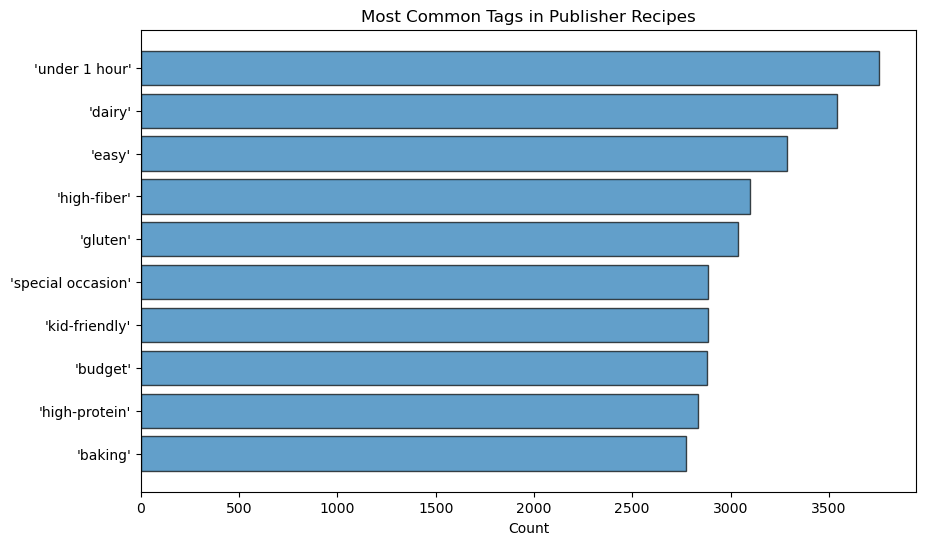

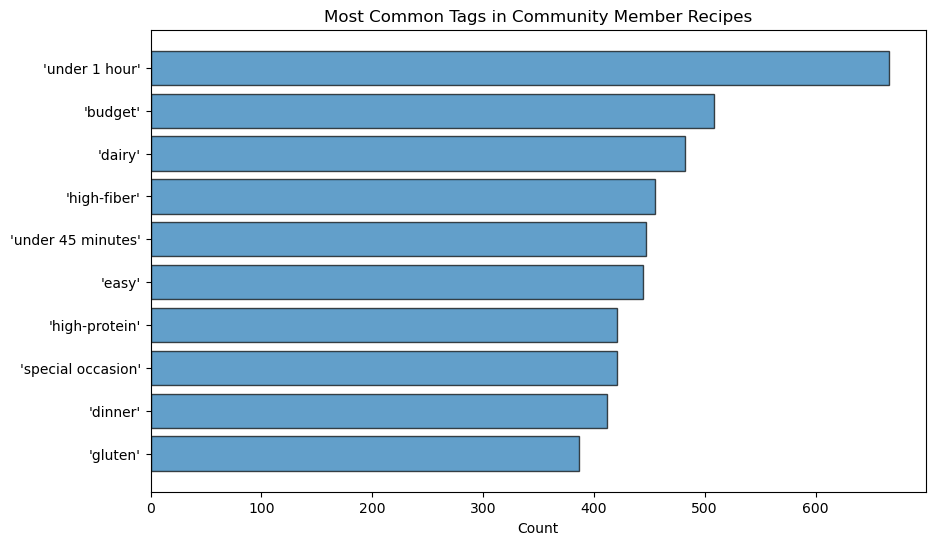

In [80]:
# Plot the most common tags for each group
def plot_common_tags(common_tags, title):
    tags, counts = zip(*common_tags)
    plt.figure(figsize=(10, 6))
    plt.barh(tags, counts, edgecolor='k', alpha=0.7)
    plt.xlabel('Count')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

    # Plot the most common tags for Publisher and Community Member recipes
plot_common_tags(most_common_publisher_tags, 'Most Common Tags in Publisher Recipes')
plot_common_tags(most_common_community_tags, 'Most Common Tags in Community Member Recipes')

**Commonalities**: Both publisher and community recipes continue to emphasize quick and easy options, with "under 1 hour," "dairy," "high-fiber," and "easy" tags being highly prevalent in both categories. Budget-friendly and special occasion tags are also significant across both groups.

**Differences**: Publisher recipes still highlight a wider array of dietary tags such as "kid-friendly" and "baking," while community member recipes place more emphasis on "under 45 minutes" and "dinner." The focus on "vegetarian" tags is less pronounced in the new data.

These updates reaffirm that publisher recipes cater to a diverse audience with an emphasis on varied dietary needs, while community recipes continue to prioritize practical, time-efficient, and budget-friendly options.

### Publisher vs. Community Recipes: Key Insights Summary

Based on the detailed analysis of score distributions, cooking times, nutritional data, popular ingredients, recipe steps, and tags, the following key differences between publisher and community recipes are identified:

1. **Scores**: Publisher recipes tend to have slightly higher average scores and a more consistent quality, indicated by a tighter distribution of scores.

2. **Cooking Times**: Publisher recipes generally take longer to prepare and cook, suggesting more complex recipes. In contrast, community recipes are quicker, reflecting simpler or more accessible meal options.

3. **Nutritional Data**: Publisher recipes often contain higher calorie, fat, and protein content, likely due to richer ingredients. Community recipes, while varied, tend to focus on balanced or lighter meals.

4. **Ingredients**: Publisher recipes commonly feature ingredients like honey, heavy cream, and cinnamon, aligning with indulgent, comfort-oriented dishes. Community recipes, however, frequently use spices like cumin and turmeric, indicating a trend toward globally-inspired and flavor-rich meals.

5. **Recipe Complexity**: Publisher recipes typically have more steps and use more ingredients, contributing to their longer preparation and cooking times. Community recipes are generally simpler, which makes them more suitable for everyday cooking.

6. **Tags**: Both types of recipes emphasize convenience, with "under 1 hour" being a top tag. However, community recipes show a greater focus on budget-friendliness and shorter cooking times, while publisher recipes emphasize diverse dietary needs, such as "gluten-free" and "high-protein" options.

In summary, publisher recipes are generally more elaborate, featuring richer ingredients and longer cooking times, while community recipes are more practical, emphasizing quicker, budget-friendly meals with a focus on robust flavors and global influences.

# 3. Data Preparation

In this chapter, the focus is on preparing the dataset for effective model training. Text features will be prepared for vectorization. Outliers will be detected and addressed to avoid skewing the model's performance. Missing values will be handled systematically to maintain data integrity and ensure comprehensive model training.

### Removing columns

In [81]:
# Drop the 'Author' and 'Recipe URL' columns
df_recipes = df_recipes.drop(columns=['Author', 'Recipe URL'])

## 3.1 Handle Outliers

Outliers can significantly affect the performance of machine learning models. Many algorithms, particularly those based on distance metrics (e.g., K-Nearest Neighbors) and linear models (e.g., Linear Regression), are sensitive to outliers. These algorithms can produce biased or skewed results when trained on data containing outliers.

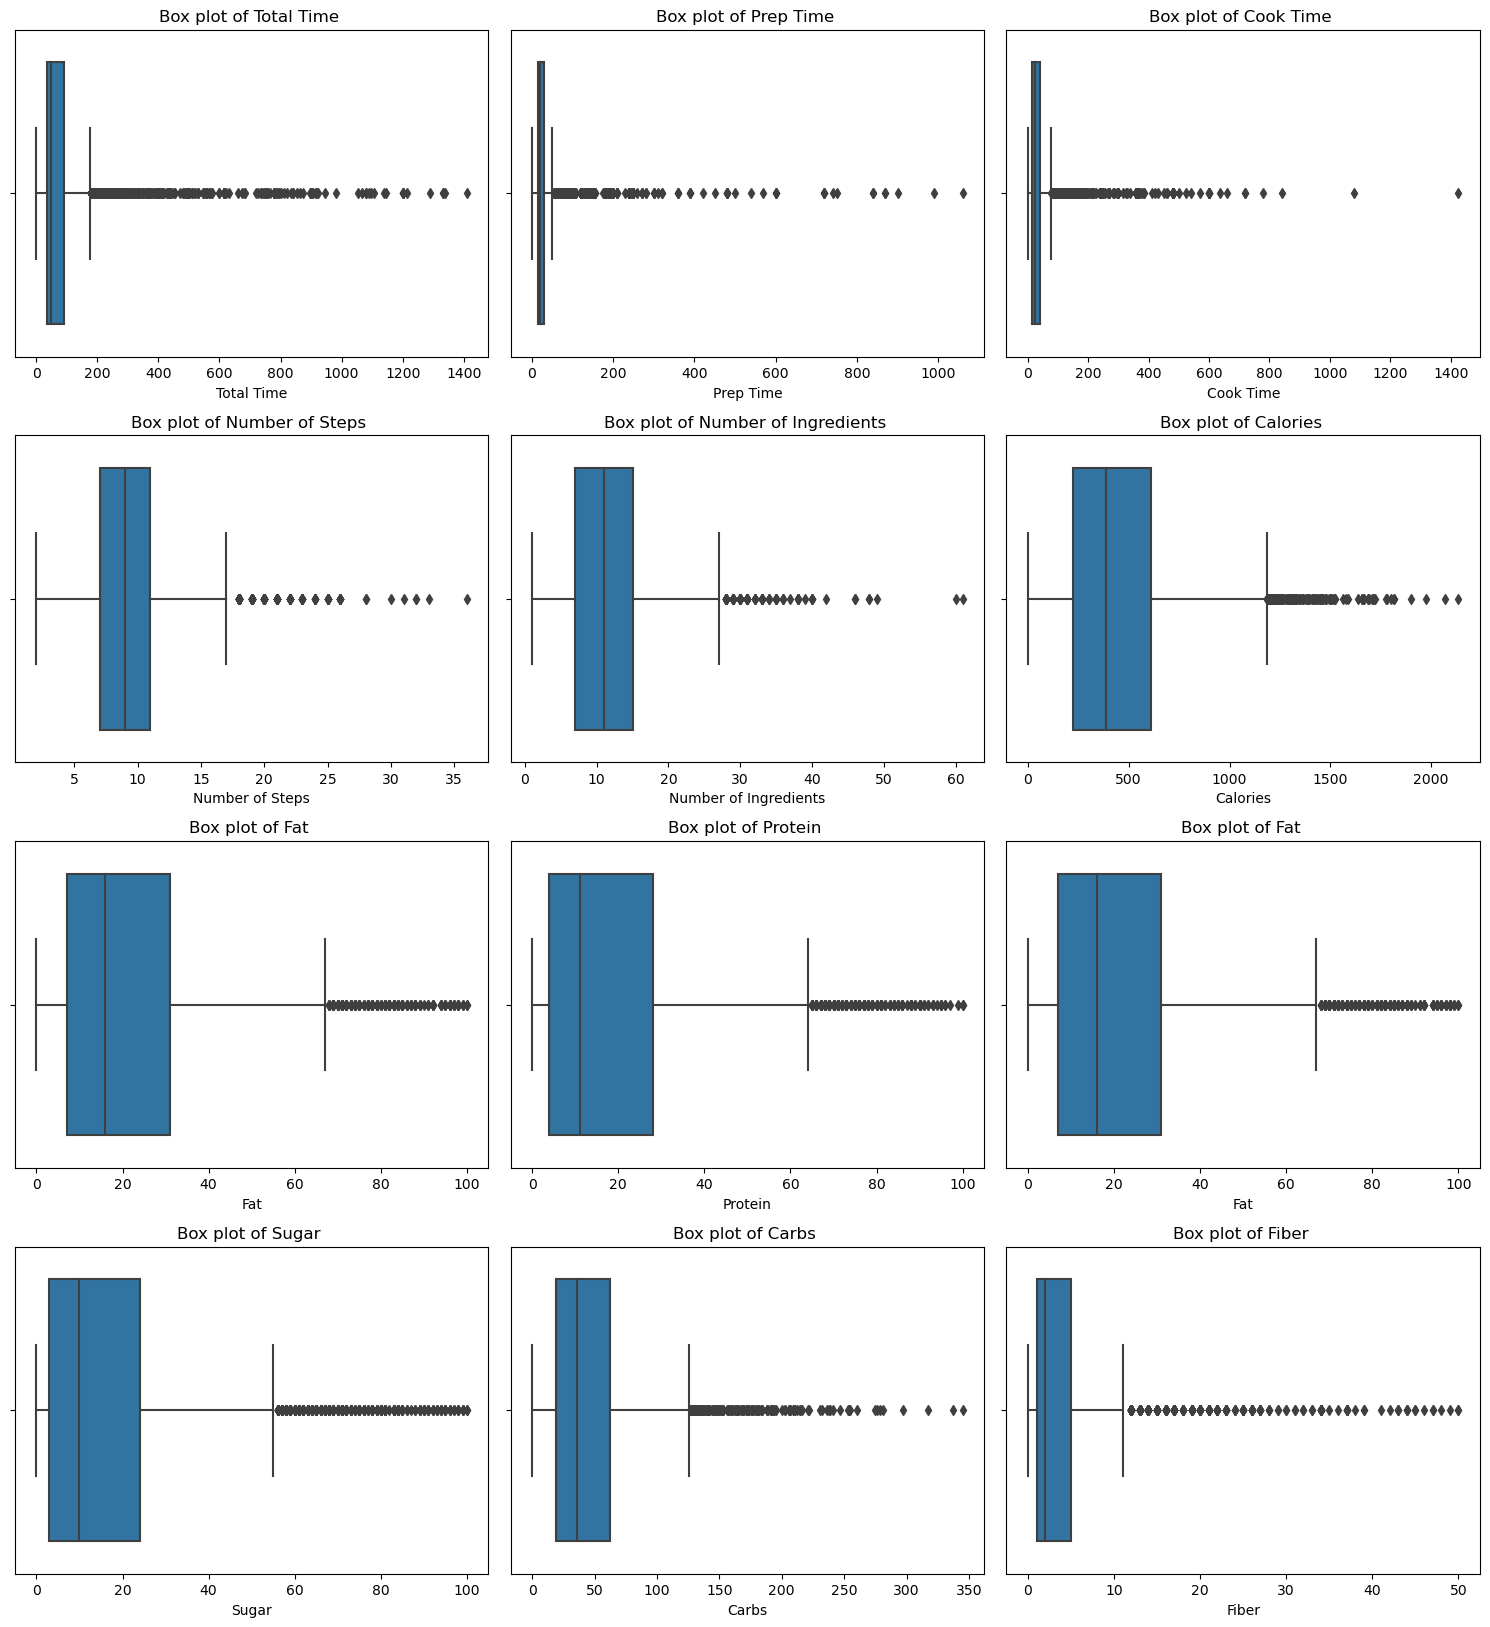

In [82]:
# List of columns to visualize
selected_columns = [
    'Total Time', 'Prep Time', 'Cook Time', 'Number of Steps', 'Number of Ingredients',
    'Calories', 'Fat', 'Protein', 'Fat', 'Sugar', 'Carbs', 'Fiber'
]

# Function to visualize data with box plots
def visualize_data(df, columns, title):
    plt.figure(figsize=(15, 20))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns) // 3 + 1, 3, i)
        sns.boxplot(x=df[col])
        plt.title(f'Box plot of {col} {title}')
    plt.tight_layout()
    plt.show()

# Visualize initial data
visualize_data(df_recipes, selected_columns, '')

In [83]:
# Cap outliers using more realistic bounds for cooking times
def cap_outliers(df, cols, upper_bounds=None):
    for col in cols:
        if upper_bounds and col in upper_bounds:
            upper_bound = upper_bounds[col]
            df.loc[df[col] > upper_bound, col] = upper_bound
        else:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df.loc[df[col] < lower_bound, col] = lower_bound
            df.loc[df[col] > upper_bound, col] = upper_bound
    return df

# Define realistic upper bounds for time-related columns
upper_bounds = {
    'cook_time': 180,  # 3 hours
    'prep_time': 120,  # 2 hours
    'total_time': 300  # 5 hours
}

# Cap outliers in the selected columns
df_recipes = cap_outliers(df_recipes, selected_columns, upper_bounds)

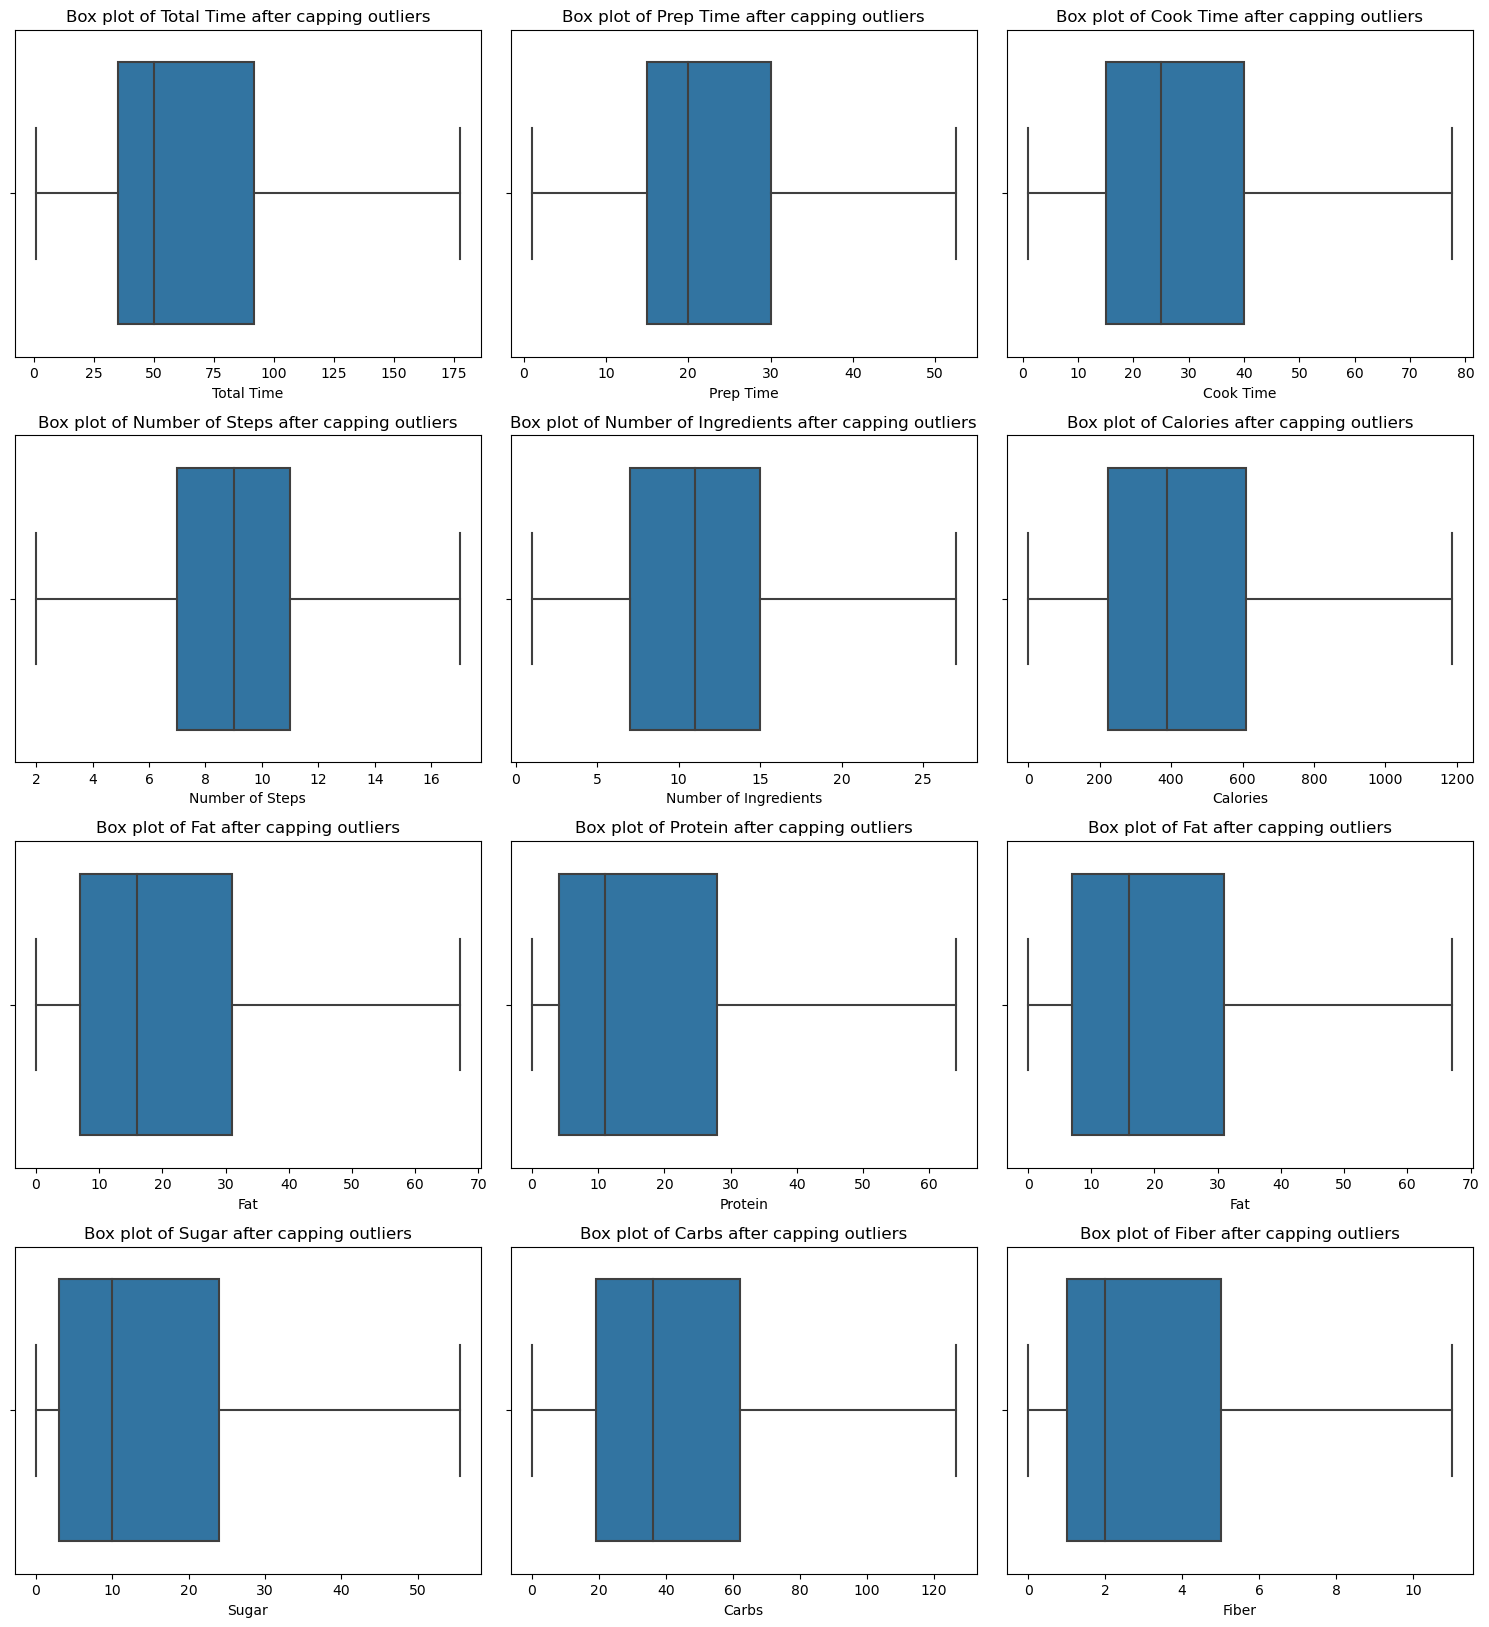

In [84]:
# Visualize data after capping outliers
visualize_data(df_recipes, selected_columns, 'after capping outliers')

In [85]:
df_recipes.describe()

,Role,Score,Total Time,Prep Time,Cook Time,Calories,Fat,Carbs,Fiber,Sugar,Protein,Number of Steps,Number of Ingredients
count,6604.000000,5144.000000,5397.000000,5408.000000,5408.000000,5982.000000,5982.000000,5982.000000,5982.000000,5982.000000,5982.000000,6604.000000,6604.000000
mean,0.311024,89.361198,71.452937,22.588757,30.721431,446.513875,20.843029,44.279338,3.396523,16.048980,17.976596,9.208813,11.541187
std,0.643371,8.753421,50.910616,14.221408,21.648172,285.681853,17.506631,32.401143,3.364683,16.326905,17.774558,3.396487,5.588978
min,0.000000,15.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,0.000000,86.000000,35.000000,15.000000,15.000000,225.000000,7.000000,19.000000,1.000000,3.000000,4.000000,7.000000,7.000000
50%,0.000000,92.000000,50.000000,20.000000,25.000000,389.000000,16.000000,36.000000,2.000000,10.000000,11.000000,9.000000,11.000000
75%,0.000000,95.000000,92.000000,30.000000,40.000000,609.000000,31.000000,62.000000,5.000000,24.000000,28.000000,11.000000,15.000000
max,2.000000,100.000000,177.500000,52.500000,77.500000,1185.000000,67.000000,126.500000,11.000000,55.500000,64.000000,17.000000,27.000000


The box plots show that the outliers have been effectively capped, resulting in more compact and controlled distributions for each column. The data is now better prepared for model training.

## 3.2 Handle Missing Values

The approach to handling missing values involves grouping recipes by categories such as Breakfast, Lunch, and Dinner, then imputing missing numerical data. This method was chosen to preserve the unique characteristics of each recipe type, ensuring that the imputed values accurately reflect the typical patterns within each group.

In [86]:
# Print columns with missing values
missing_values = df_recipes.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print("Columns with missing values:\n", missing_columns)

Columns with missing values:
 Score         1460
Total Time    1207
Prep Time     1196
Cook Time     1196
Calories       622
Fat            622
Carbs          622
Fiber          622
Sugar          622
Protein        622
dtype: int64


In [87]:
# Define keywords for grouping
keywords = ['Breakfast', 'Lunch', 'Dinner', 'Desserts', 'Snacks']

# Function to categorize based on the first matching keyword
def categorize_recipe(tags):
    for keyword in keywords:
        if keyword.lower() in tags.lower():
            return keyword
    return 'Other'

# Apply the function to the Tags column
df_recipes['Categories'] = df_recipes['Tags'].apply(categorize_recipe)

# Check if any recipe belongs to more than one category
multiple_categories = df_recipes[df_recipes['Categories'].apply(len) > 1]

In [88]:
# Group by the new category and calculate summary statistics
for category in df_recipes['Categories'].unique():
    category_recipes = df_recipes[df_recipes['Categories'] == category]
    summary_stats = category_recipes.describe()

    # Print the summary statistics for the category
    print(f"Summary Statistics for {category} Recipes:")
    print(summary_stats)
    print("\n" + "-"*50 + "\n")

    # Get the total count of recipes in this category
    total_recipes = len(category_recipes)
    print(f"Total number of recipes in {category} category: {total_recipes}\n")

    # Check for missing values in this category
    missing_values = category_recipes.isnull().sum()
    missing_columns = missing_values[missing_values > 0]
    print(f"Missing Values in {category} Recipes (out of {total_recipes}):\n", missing_columns)
    print("\n" + "="*50 + "\n")

Summary Statistics for Lunch Recipes:
              Role        Score   Total Time    Prep Time    Cook Time  \
count  1486.000000  1132.000000  1268.000000  1268.000000  1268.000000   
mean      0.335801    91.031802    61.906546    20.831230    28.430599   
std       0.659270     8.081091    47.267970    12.882119    20.609897   
min       0.000000    21.000000     4.000000     1.000000     1.000000   
25%       0.000000    89.000000    30.000000    10.000000    15.000000   
50%       0.000000    93.000000    45.000000    15.000000    20.000000   
75%       0.000000    96.000000    75.000000    30.000000    35.000000   
max       2.000000   100.000000   177.500000    52.500000    77.500000   

          Calories          Fat        Carbs       Fiber        Sugar  \
count  1351.000000  1351.000000  1351.000000  1351.00000  1351.000000   
mean    484.499630    22.626203    43.236491     4.23168     9.460770   
std     295.170901    18.534257    32.714349     3.53548    10.753894   
min

Based on the summary statistics for each recipe category, it is recommended to use **median imputation** across all categories due to the slightly skewed distributions. The median is more robust and less affected by extreme values, making it a better choice for imputation in this context.

In [89]:
# Step 1: Filter for numeric columns, excluding 'Role'
numeric_columns = df_recipes.select_dtypes(include=['number']).columns
numeric_columns = numeric_columns.drop('Role')

# Calculate the median for each category based on numeric columns only
category_medians = df_recipes.groupby('Categories')[numeric_columns].median()

# Step 2: Define a function to impute missing values
def impute_missing_values(row):
    category = row['Categories']
    for column in numeric_columns:
        if pd.isnull(row[column]):
            row[column] = category_medians.loc[category, column]
    return row

# Apply the imputation function to the DataFrame
df_recipes = df_recipes.apply(impute_missing_values, axis=1)

# Step 3: Scaling the features
scaler = StandardScaler()

# Apply scaling to the numeric columns, excluding 'Role'
df_recipes[numeric_columns] = scaler.fit_transform(df_recipes[numeric_columns])

In [90]:
# Check if all missing values are imputed
missing_values_after = df_recipes.isnull().sum()
print("Missing values after imputation:\n", missing_values_after)

Missing values after imputation:
 Recipe Title             0
Role                     0
Score                    0
Total Time               0
Prep Time                0
Cook Time                0
Ingredients              0
Preparation Steps        0
Calories                 0
Fat                      0
Carbs                    0
Fiber                    0
Sugar                    0
Protein                  0
Tags                     0
Number of Steps          0
Number of Ingredients    0
Categories               0
dtype: int64


## 3.3 Handle Text Data

Handling text data is a crucial step in preparing datasets for machine learning, particularly when working with natural language elements like recipe titles, ingredients, instructions, and tags. This chapter focuses on transforming raw text into a structured format that can be effectively utilized in predictive models.

### Flatten ingredients, instructions and tags lists

In [91]:
# Define the function to flatten ingredients
def flatten_ingredients(ingredients_list):
    if isinstance(ingredients_list, str):
        ingredients_list = eval(ingredients_list)
    if isinstance(ingredients_list, list):
        flattened = [ingredient for ingredient in ingredients_list]
        return '; '.join(flattened)
    return ''

# Define the function to flatten instructions
def flatten_instructions(instructions_list):
    if isinstance(instructions_list, str):
        instructions_list = eval(instructions_list)
    if isinstance(instructions_list, list):
        steps = [instruction for instruction in instructions_list]
        return ' '.join(steps)
    return ''

# Define the function to flatten tags
def flatten_tags(tags_list):
    if isinstance(tags_list, str):
        tags_list = eval(tags_list)
    if isinstance(tags_list, list):
        flattened = [tag for tag in tags_list]
        return '; '.join(flattened)
    return ''

# Apply the functions to the DataFrame
df_recipes['Ingredients'] = df_recipes['Ingredients'].apply(flatten_ingredients)
df_recipes['Preparation Steps'] = df_recipes['Preparation Steps'].apply(flatten_instructions)
df_recipes['Tags'] = df_recipes['Tags'].apply(flatten_tags)

df_recipes

,Recipe Title,Role,Score,Total Time,Prep Time,Cook Time,Ingredients,Preparation Steps,Calories,Fat,Carbs,Fiber,Sugar,Protein,Tags,Number of Steps,Number of Ingredients,Categories
0,Roasted Moroccan Carrots With Baba Ganoush,1,0.405851,-0.835194,-0.881659,-0.480881,"1 bunch dutch carrots, washed and tops trimmed...",Place carrots on a baking dish lined with baki...,-1.348480,-0.977627,-1.150841,-0.395568,-0.877153,-0.906120,Meal; Dinner; Weeknight; Kosher; Halal; Budget...,-1.533704,-0.633650,Lunch
1,Edamame Truffle Dumplings In Miso Broth,1,0.405851,0.021869,1.408850,0.023633,1 package frozen shelled edamame; 2 tablespoon...,Cook the frozen edamame according the package ...,-0.100960,-0.261258,0.174297,0.841478,-0.813823,0.023969,Cuisine; Asian; Japanese; Soy; Gluten; Allerge...,0.527405,1.334659,Lunch
2,Grilled Napa Cabbage Fattoush Salad,1,0.405851,-0.620928,-0.118156,-0.480881,"1 head medium napa cabbage; 1 small red onion,...",Preheat the grill and preheat the oven to 375°...,-0.038767,0.514809,-0.375150,-0.395568,-0.623833,-0.499206,Cuisine; European; Mediterranean; Kosher; Dair...,-0.061484,1.513596,Lunch
3,Roasted Tomato Basil Soup,0,0.150529,-0.942327,-1.263410,-0.480881,"1 tablespoon olive oil; 1 yellow onion, diced;...","In a large pot over medium heat, combine the o...",-1.436282,-1.216417,-1.118520,-0.704830,-0.877153,-0.964250,Meal; Dinner; Soups; Budget; High-Fiber; Low-F...,-0.944816,0.261036,Lunch
4,Tuna Salad With Roasted Veggies,0,0.788833,-0.728061,-0.499907,-0.480881,"1 cup green beans (360 g), trimmed; 2 cups bab...",Preheat the oven to 375˚F (190˚C). On a baking...,0.495361,-0.082165,0.238938,1.150739,-0.307184,1.826015,Meal; Lunch; Salads; Dairy; Fish; European; Di...,0.232960,1.513596,Lunch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6599,Carrot Cake Granola Balls,2,0.661172,-0.406662,-0.499907,-0.228624,1 ¼ cups oats (125 g); ⅖ cup walnuts (40 g); 1...,"Add oats, walnuts and ground almonds to a larg...",-1.000931,-0.619442,-0.892277,-0.395568,-0.687163,-0.789859,Meal; Dinner; Weeknight; Budget; Peanuts; Tree...,-0.650372,-0.633650,Breakfast
6600,Date-Nut Energy Balls,1,-0.104792,0.129002,-0.118156,-0.228624,1 cup whole almonds (125 g); 1 cup date (175 g...,Put all ingredients in a food processor and pr...,-1.319213,-0.917930,-1.183161,-0.704830,-0.750493,-0.906120,Meal; Snacks; Kosher; Halal; Tree nuts; High-F...,-1.533704,-1.349398,Desserts
6601,Cheesy Pretzel Ring Dip,0,0.661172,-0.192396,0.645347,0.023633,32 oz pizza dough (910 g); 5 cups water (1 ¼ L...,Preheat the oven to 425°F (220°C). Cut pizza d...,-0.082668,0.156624,-0.245868,-0.704830,-0.877153,-0.150423,Seasonal; Occasion; Party; Budget; Dairy; Glut...,1.410737,-0.275776,Snacks
6602,Pigs In A Blanket Stadium,0,0.022868,2.057395,0.645347,2.420073,"4 sheets puff pastry, chilled; 2 eggs, beaten;...",Preheat oven to 350°F (180°C). Roll out the pu...,0.330733,1.410271,-0.892277,-1.014091,-1.003812,-0.034162,Seasonal; Occasion; Game Day; Dairy; Gluten; E...,1.410737,-0.991524,Snacks


### Data lemmatization and vecotrization

The approach involves using TF-IDF vectorization to convert text data from recipe titles, ingredients, preparation steps, tags, and categories into numerical features. Given the varying, bur rather **shorter lengths and complexity of these texts**, selecting **20 features** is a reasonable compromise. It captures the most relevant information without overwhelming the model with too many features.

In [92]:
# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize text
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

# Custom stop words list including common cooking terms
custom_stop_words = ['add', 'salt', 'pepper', 'mix', 'cook', 'stir', 'heat', 'serve', 'use', 'recipe',
                     'tablespoon', 'teaspoon', 'cup', 'minutes', 'hour', 'high', 'medium', 'low',
                     'egg', 'lb', 'water', 'well', 'prep', 'taste', 'chop']

# Combine custom stop words with standard English stop words
stop_words_combined = custom_stop_words + nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kurze\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kurze\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kurze\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [93]:
# Function to vectorize a text column with TF-IDF and lemmatization
def vectorize_text_column(df, column_name, max_features=20):
    # Apply lemmatization to the text column
    df[column_name] = df[column_name].fillna('').apply(lemmatize_text)

    # Vectorize with TF-IDF
    tfidf = TfidfVectorizer(max_features=max_features, stop_words=stop_words_combined)
    tfidf_matrix = tfidf.fit_transform(df[column_name])
    df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'{column_name}_{feat}' for feat in tfidf.get_feature_names_out()])
    return df_tfidf

# Always start from the original DataFrame
# Vectorize each text column separately with lemmatization
df_tfidf_title = vectorize_text_column(df_recipes.copy(), 'Recipe Title', max_features=20)
df_tfidf_ingredients = vectorize_text_column(df_recipes.copy(), 'Ingredients', max_features=20)
df_tfidf_prep_steps = vectorize_text_column(df_recipes.copy(), 'Preparation Steps', max_features=20)
df_tfidf_tags = vectorize_text_column(df_recipes.copy(), 'Tags', max_features=20)
df_tfidf_categories = vectorize_text_column(df_recipes.copy(), 'Categories', max_features=20)

# Concatenate all the TF-IDF DataFrames with the original DataFrame
df_recipes_tfidf = pd.concat([df_recipes.reset_index(drop=True),
                              df_tfidf_title, df_tfidf_ingredients,
                              df_tfidf_prep_steps, df_tfidf_tags,
                              df_tfidf_categories], axis=1)

# Drop the original text columns since they are now vectorized
df_recipes_tfidf.drop(columns=['Recipe Title', 'Ingredients', 'Preparation Steps', 'Tags', 'Categories'], inplace=True)

# Display the first few rows of the transformed DataFrame
df_recipes_tfidf.head()

,Role,Score,Total Time,Prep Time,Cook Time,Calories,Fat,Carbs,Fiber,Sugar,...,Tags_north,Tags_occasion,Tags_pan,Tags_protein,Tags_special,Categories_breakfast,Categories_desserts,Categories_dinner,Categories_lunch,Categories_snacks
0,1,0.405851,-0.835194,-0.881659,-0.480881,-1.348480,-0.977627,-1.150841,-0.395568,-0.877153,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
1,1,0.405851,0.021869,1.408850,0.023633,-0.100960,-0.261258,0.174297,0.841478,-0.813823,...,0.0,0.289768,0.358221,0.308068,0.308969,0.0,0.0,0.0,1.0,0.0
2,1,0.405851,-0.620928,-0.118156,-0.480881,-0.038767,0.514809,-0.375150,-0.395568,-0.623833,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
3,0,0.150529,-0.942327,-1.263410,-0.480881,-1.436282,-1.216417,-1.118520,-0.704830,-0.877153,...,0.0,0.000000,0.581019,0.249836,0.000000,0.0,0.0,0.0,1.0,0.0
4,0,0.788833,-0.728061,-0.499907,-0.480881,0.495361,-0.082165,0.238938,1.150739,-0.307184,...,0.0,0.000000,0.306376,0.263481,0.000000,0.0,0.0,0.0,1.0,0.0


# 4. Feature Importance and Selection

Selecting the most relevant features is crucial for building effective predictive models. This chapter focuses on the feature selection process, specifically examining the top factors influencing recipe success within two distinct categories: professionally curated (Publisher) recipes and user-generated (Community) recipes. By calculating the correlation between various features and the recipe success metric (Score), the top 20 features are identified that are most strongly associated with success in each category.

## 4.1 Key popularity factors

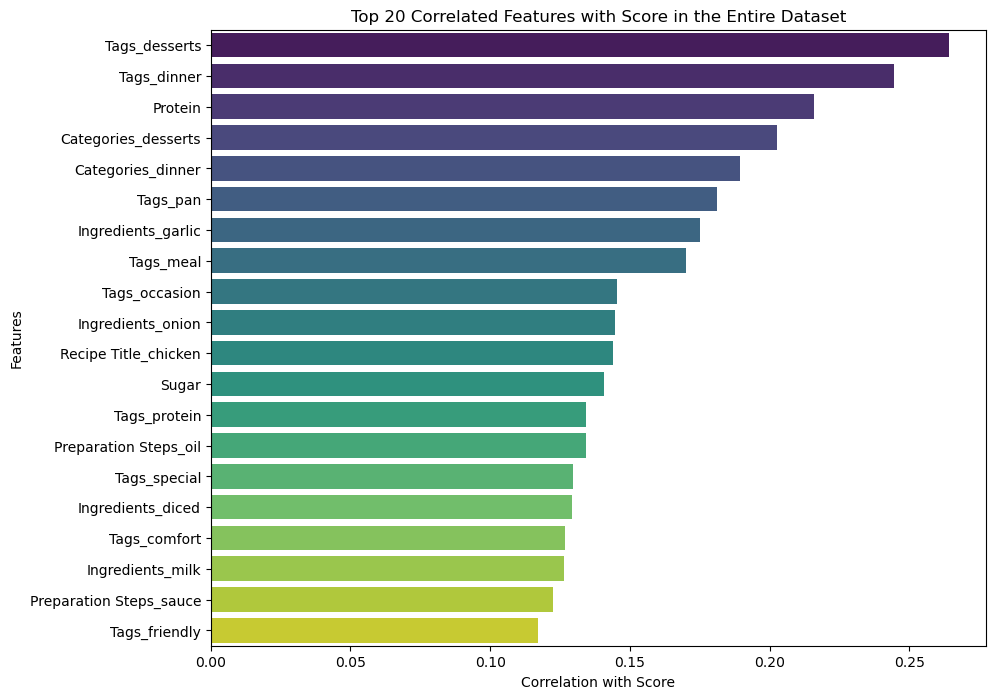

In [94]:
# Calculate the correlation matrix for the entire dataset
corr_matrix = df_recipes_tfidf.corr()

# Extract the top 20 correlated features with 'Score'
top_corr_features = corr_matrix['Score'].abs().sort_values(ascending=False).head(21)[1:]  # Exclude 'Score' itself

# Plotting the top 20 correlated features with Score
plt.figure(figsize=(10, 8))
sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette="viridis")
plt.title('Top 20 Correlated Features with Score in the Entire Dataset')
plt.xlabel('Correlation with Score')
plt.ylabel('Features')
plt.show()

### Learnings:

1. **Tag-Based Features:**
   - **Tags_desserts** and **Tags_dinner** are the top correlated features, suggesting that recipes tagged with these categories tend to have higher scores. This indicates that dessert and dinner recipes are particularly popular among users.
   - Other tags like **Tags_pan**, **Tags_meal**, **Tags_occasion**, **Tags_protein**, **Tags_special**, **Tags_comfort**, and **Tags_friendly** also show strong correlations, indicating that specific meal types, occasions, and dietary preferences are key factors in recipe success.

2. **Ingredient-Based Features:**
   - Ingredients like **garlic**, **onion**, **diced**, and **milk** are among the top 20 correlated features. This suggests that recipes containing these ingredients are more likely to be successful. Ingredients like garlic and onion are common in a variety of popular dishes, which could explain their high correlation.
   - The presence of **sugar** and **protein** (as nutritional content) being highly correlated with score also indicates that the nutritional profile of a recipe, particularly its protein content, can be a determinant of its popularity.

3. **Category-Based Features:**
   - **Categories_desserts** and **Categories_dinner** again confirm the importance of these meal types. Their strong correlation suggests that these categories are consistently popular, irrespective of other features.

4. **Preparation Steps and Recipe Titles:**
   - Specific preparation steps like **sauce** and **oil** are also correlated, indicating that certain cooking methods or steps may contribute to the success of a recipe.
   - The presence of specific recipe titles like **Recipe Title_chicken** also suggests that certain popular recipe types (like chicken dishes) have a significant impact on the score.

In [ ]:
X = df_recipes_tfidf.drop(columns=['Score'])  # Features
y = df_recipes_tfidf['Score']  # Target

# Train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 important features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")
plt.title('Top 20 Feature Importances from Random Forest')
plt.show()


### Learnings:

1. **Tag-Based Features:**
   - **Tags_desserts** once again emerges as the most important feature, which reinforces the earlier finding that dessert-related recipes are highly popular and influential in determining a recipe's success.
   - Other important tags include **Tags_occasion**, **Tags_dairy**, **Tags_free**, and **Tags_pan**. These tags likely correspond to meal types, dietary restrictions, or specific ingredients that users favor, and they play a significant role in how the recipes are scored.

2. **Recipe Title:**
   - The feature **Recipe Title_potato** is ranked second in importance, suggesting that recipes with "potato" in their title are particularly influential in the model's predictions. This could reflect a user preference for potato-based dishes or indicate that such recipes tend to perform well overall.

3. **Time-Based Features:**
   - **Total Time** is included among the top features, which implies that the overall time investment required to prepare a recipe is an essential consideration for users, potentially affecting their satisfaction and the recipe's score.

### Evaluating Learnings:

- **Feature Importance vs. Correlation:** While the correlation analysis focuses on linear relationships between features and the target variable, feature importance from a Random Forest model considers the impact of features across various decision paths. This gives a more nuanced view of which features are truly influential in predicting recipe success.

- **Practical Implications:** Knowing that certain tags, ingredients, and preparation steps are critical can guide recipe development, marketing, and even the structuring of recipe databases to emphasize these features for improved user engagement and satisfaction.

## 4.2 Key popularity factors per recipe type

In [ ]:
# Split the dataset into Publisher and Community recipes
publisher_recipes = df_recipes_tfidf[df_recipes_tfidf['Role'] == 0]
community_recipes = df_recipes_tfidf[df_recipes_tfidf['Role'] == 1]

# Calculate the correlation matrices
corr_publisher = publisher_recipes.corr()
corr_community = community_recipes.corr()

# Extract the top 20 correlated features with 'Score' for Publisher recipes
top_corr_publisher = corr_publisher['Score'].abs().sort_values(ascending=False).head(21)[1:]

# Extract the top 20 correlated features with 'Score' for Community recipes
top_corr_community = corr_community['Score'].abs().sort_values(ascending=False).head(21)[1:]

# Plotting the top 20 correlated features for Publisher recipes
plt.figure(figsize=(10, 8))
sns.barplot(x=top_corr_publisher.values, y=top_corr_publisher.index, palette="viridis")
plt.title('Top 20 Correlated Features with Score in Publisher Recipes')
plt.xlabel('Correlation with Score')
plt.ylabel('Features')
plt.show()

# Plotting the top 20 correlated features for Community recipes
plt.figure(figsize=(10, 8))
sns.barplot(x=top_corr_community.values, y=top_corr_community.index, palette="viridis")
plt.title('Top 20 Correlated Features with Score in Community Recipes')
plt.xlabel('Correlation with Score')
plt.ylabel('Features')
plt.show()

### Analysis of Publisher and Community Recipes Based on Correlated Features

#### Publisher Recipes:
In the publisher recipes, the top features correlated with the score are primarily related to specific types of dishes, ingredients, and cooking methods. Tags such as `Tags_desserts`, `Tags_dinner`, and `Categories_desserts` have the highest correlations with the recipe scores, suggesting that recipes labeled as desserts and dinners tend to be more popular or higher scoring. Additionally, ingredients like `Protein` and `Ingredients_garlic`, along with preparation steps like `Preparation Steps_oil`, are also highly correlated, indicating that protein-rich meals, meals with garlic, and those involving oil in their preparation are more likely to receive higher scores. The emphasis on specific meal types and essential ingredients reflects the structured and targeted nature of publisher recipes, where well-defined categories and classic ingredients play a significant role in determining success.

#### Community Recipes:
For community recipes, the correlation patterns show a different trend. While `Tags_dinner` and `Tags_desserts` are still prominent, indicating their universal appeal, the importance of ingredient variety is more pronounced. Features like `Number of Ingredients`, `Ingredients_garlic`, and `Preparation Steps_sugar` show strong correlations, suggesting that complexity and sweetness are key factors in higher-scoring community recipes. The inclusion of `Categories_desserts` and `Recipe Title_cake` highlights the community's preference for sweet dishes, often home-baked and involving multiple ingredients. This indicates that community-driven content may favor recipes that allow for creativity and customization, often appealing to the indulgent and comfort food categories.

# 5. Baseline Model Training and Evaluation

This chapter introduces the foundational step of developing predictive models by using **well-established machine learning techniques** on the dataset.

This process involves splitting the data into two subsets, namely **publisher-curated** and **community-generated recipes**, and then defining the **target variable**, which in this case is the recipe `score`.

A variety of regression models are selected for evaluation. The models are trained and fine-tuned using **cross-validation** and **hyperparameter optimization** to identify the best-performing configurations.

In [43]:
# Split the data into Publisher and Community subsets
publisher_recipes = df_recipes_tfidf[df_recipes_tfidf['Role'] == 0]
community_recipes = df_recipes_tfidf[df_recipes_tfidf['Role'] == 1]

# Define the feature set and target variable
X_pub = publisher_recipes.drop(columns=['Score', 'Role'])
y_pub = publisher_recipes['Score']

X_comm = community_recipes.drop(columns=['Score', 'Role'])
y_comm = community_recipes['Score']

In [44]:
# List of models to evaluate
model_dict = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'ElasticNet Regression': ElasticNet(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
}

# Define parameter grids for RandomizedSearchCV
param_grids = {
    'Linear Regression': {},  # No hyperparameters to tune for plain linear regression
    'Ridge Regression': {'alpha': [0.1, 1, 10, 100]},
    'ElasticNet Regression': {'alpha': [0.001, 0.01, 0.1, 1], 'l1_ratio': [0.1, 0.5, 0.9]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
}

In [ ]:
# Function to train and evaluate models with cross-validation
def train_and_evaluate(X, y, models, param_grids, save_path='best_models/test'):
    results = {}
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Create directory to save models if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        param_grid = param_grids[model_name]
        print(f"Hyperparameters being tuned: {param_grid}")

        # Perform RandomizedSearchCV to find the best hyperparameters
        search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=kfold, scoring='r2', random_state=42, n_jobs=-1)
        search.fit(X, y)

        # Get the best model and its hyperparameters
        best_model = search.best_estimator_
        best_params = search.best_params_
        print(f"Best hyperparameters found: {best_params}")

        # Save the best model
        model_filename = os.path.join(save_path, f'{model_name}_best_model.pkl')
        joblib.dump(best_model, model_filename)
        print(f"Saved best model for {model_name} to {model_filename}")

        # Cross-validation on the best model
        mse_scores = -cross_val_score(best_model, X, y, cv=kfold, scoring='neg_mean_squared_error')
        mae_scores = -cross_val_score(best_model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
        r2_scores = cross_val_score(best_model, X, y, cv=kfold, scoring='r2')

        # Calculate average scores
        mse_mean = mse_scores.mean()
        mae_mean = mae_scores.mean()
        r2_mean = r2_scores.mean()

        print(f"Cross-Validation Results - MSE: {mse_mean:.4f}, MAE: {mae_mean:.4f}, R2: {r2_mean:.4f}")

        # Store the results
        results[model_name] = {
            'MSE': mse_mean,
            'MAE': mae_mean,
            'R2': r2_mean,
            'Best Params': best_params,
            'Best Estimator': best_model
        }

    return results

In [ ]:
# Function to get top features or return all features
def get_top_features(X, y, num_features):
    if num_features == 'all':
        return X  # Return all features if 'all' is selected
    else:
        num_features = int(num_features)
        corrs = X.corrwith(y).abs().sort_values(ascending=False)
        top_features = corrs.head(num_features).index.tolist()
        
        # Fallback if not enough features are selected
        if len(top_features) == 0:
            return X
        
        return X[top_features]

# Define the number of top features to evaluate
top_feature_sizes = ['all', 20, 50, 70]

In [ ]:
X_pub_df = pd.DataFrame(X_pub, columns=X_pub.columns)
y_pub_series = pd.Series(y_pub, name='Score')

X_comm_df = pd.DataFrame(X_comm, columns=X_comm.columns)
y_comm_series = pd.Series(y_comm, name='Score')

# Iterate over the different sizes of top features
for top_size in top_feature_sizes:
    # Extract the top correlated features for the current size or all features
    X_pub_top = get_top_features(X_pub_df, y_pub_series, top_size)
    X_comm_top = get_top_features(X_comm_df, y_comm_series, top_size)

    # Handle empty feature sets
    if X_pub_top.shape[1] == 0:
        print(f"No features selected for Publisher data with top size '{top_size}'. Reverting to all features.")
        X_pub_top = X_pub_df  # Use all features
    
    if X_comm_top.shape[1] == 0:
        print(f"No features selected for Community data with top size '{top_size}'. Reverting to all features.")
        X_comm_top = X_comm_df  # Use all features

    # Evaluate models using the selected features
    feature_name = f"Top {top_size} Features"
    print(f"\nEvaluating {feature_name} for Publisher Recipes:")
    results_pub = train_and_evaluate(X_pub_top, y_pub, model_dict, param_grids, save_path=f'best_models/publisher_2/{feature_name}')

    print(f"\nEvaluating {feature_name} for Community Recipes:")
    results_comm = train_and_evaluate(X_comm_top, y_comm, model_dict, param_grids, save_path=f'best_models/community_2/{feature_name}')

In [ ]:
# Data for Publisher Recipes across different feature sets
publisher_results = {
    'Top 20 Features': {
        'Linear Regression': {'MSE': 1.0185, 'MAE': 0.6609, 'R2': 0.0759},
        'Ridge Regression': {'MSE': 1.0180, 'MAE': 0.6596, 'R2': 0.0763},
        'ElasticNet Regression': {'MSE': 1.0190, 'MAE': 0.6595, 'R2': 0.0754},
        'Random Forest': {'MSE': 1.0505, 'MAE': 0.6709, 'R2': 0.0485},
        'Gradient Boosting': {'MSE': 1.0263, 'MAE': 0.6620, 'R2': 0.0673}
    },
    'Top 50 Features': {
        'Linear Regression': {'MSE': 1.0080, 'MAE': 0.6584, 'R2': 0.0856},
        'Ridge Regression': {'MSE': 1.0048, 'MAE': 0.6553, 'R2': 0.0885},
        'ElasticNet Regression': {'MSE': 1.0051, 'MAE': 0.6534, 'R2': 0.0883},
        'Random Forest': {'MSE': 1.0247, 'MAE': 0.6660, 'R2': 0.0719},
        'Gradient Boosting': {'MSE': 1.0060, 'MAE': 0.6570, 'R2': 0.0837}
    },
    'Top 70 Features': {
        'Linear Regression': {'MSE': 1.0123, 'MAE': 0.6606, 'R2': 0.0820},
        'Ridge Regression': {'MSE': 1.0059, 'MAE': 0.6548, 'R2': 0.0879},
        'ElasticNet Regression': {'MSE': 1.0050, 'MAE': 0.6549, 'R2': 0.0888},
        'Random Forest': {'MSE': 1.0293, 'MAE': 0.6697, 'R2': 0.0677},
        'Gradient Boosting': {'MSE': 1.0141, 'MAE': 0.6581, 'R2': 0.0789}
    },
    'All Features': {
        'Linear Regression': {'MSE': 1.0360, 'MAE': 0.6758, 'R2': 0.0592},
        'Ridge Regression': {'MSE': 0.9985, 'MAE': 0.6540, 'R2': 0.0945},
        'ElasticNet Regression': {'MSE': 0.9989, 'MAE': 0.6534, 'R2': 0.0943},
        'Random Forest': {'MSE': 1.0188, 'MAE': 0.6598, 'R2': 0.0763},
        'Gradient Boosting': {'MSE': 1.0153, 'MAE': 0.6583, 'R2': 0.0802}
    }
}

# Data for Community Recipes across different feature sets
community_results = {
    'Top 20 Features': {
        'Linear Regression': {'MSE': 0.3231, 'MAE': 0.2764, 'R2': 0.1118},
        'Ridge Regression': {'MSE': 0.3227, 'MAE': 0.2753, 'R2': 0.1135},
        'ElasticNet Regression': {'MSE': 0.3234, 'MAE': 0.2746, 'R2': 0.1112},
        'Random Forest': {'MSE': 0.3476, 'MAE': 0.2698, 'R2': 0.0436},
        'Gradient Boosting': {'MSE': 0.3513, 'MAE': 0.3229, 'R2': 0.0519}
    },
    'Top 50 Features': {
        'Linear Regression': {'MSE': 0.3378, 'MAE': 0.2886, 'R2': 0.0359},
        'Ridge Regression': {'MSE': 0.3156, 'MAE': 0.2668, 'R2': 0.1577},
        'ElasticNet Regression': {'MSE': 0.3151, 'MAE': 0.2642, 'R2': 0.1570},
        'Random Forest': {'MSE': 0.3382, 'MAE': 0.2562, 'R2': -0.0094},
        'Gradient Boosting': {'MSE': 0.3389, 'MAE': 0.3045, 'R2': 0.0794}
    },
    'Top 70 Features': {
        'Linear Regression': {'MSE': 0.3500, 'MAE': 0.3113, 'R2': -0.0807},
        'Ridge Regression': {'MSE': 0.3098, 'MAE': 0.2652, 'R2': 0.1790},
        'ElasticNet Regression': {'MSE': 0.3085, 'MAE': 0.2662, 'R2': 0.1770},
        'Random Forest': {'MSE': 0.3380, 'MAE': 0.2577, 'R2': -0.0864},
        'Gradient Boosting': {'MSE': 0.3398, 'MAE': 0.3053, 'R2': 0.0765}
    },
    'All Features': {
        'Linear Regression': {'MSE': 0.5327, 'MAE': 0.4450, 'R2': -0.7980},
        'Ridge Regression': {'MSE': 0.2937, 'MAE': 0.2265, 'R2': 0.2365},
        'ElasticNet Regression': {'MSE': 0.2930, 'MAE': 0.2183, 'R2': 0.2447},
        'Random Forest': {'MSE': 0.3585, 'MAE': 0.2576, 'R2': -0.0802},
        'Gradient Boosting': {'MSE': 0.3412, 'MAE': 0.2924, 'R2': 0.0877}
    }
}

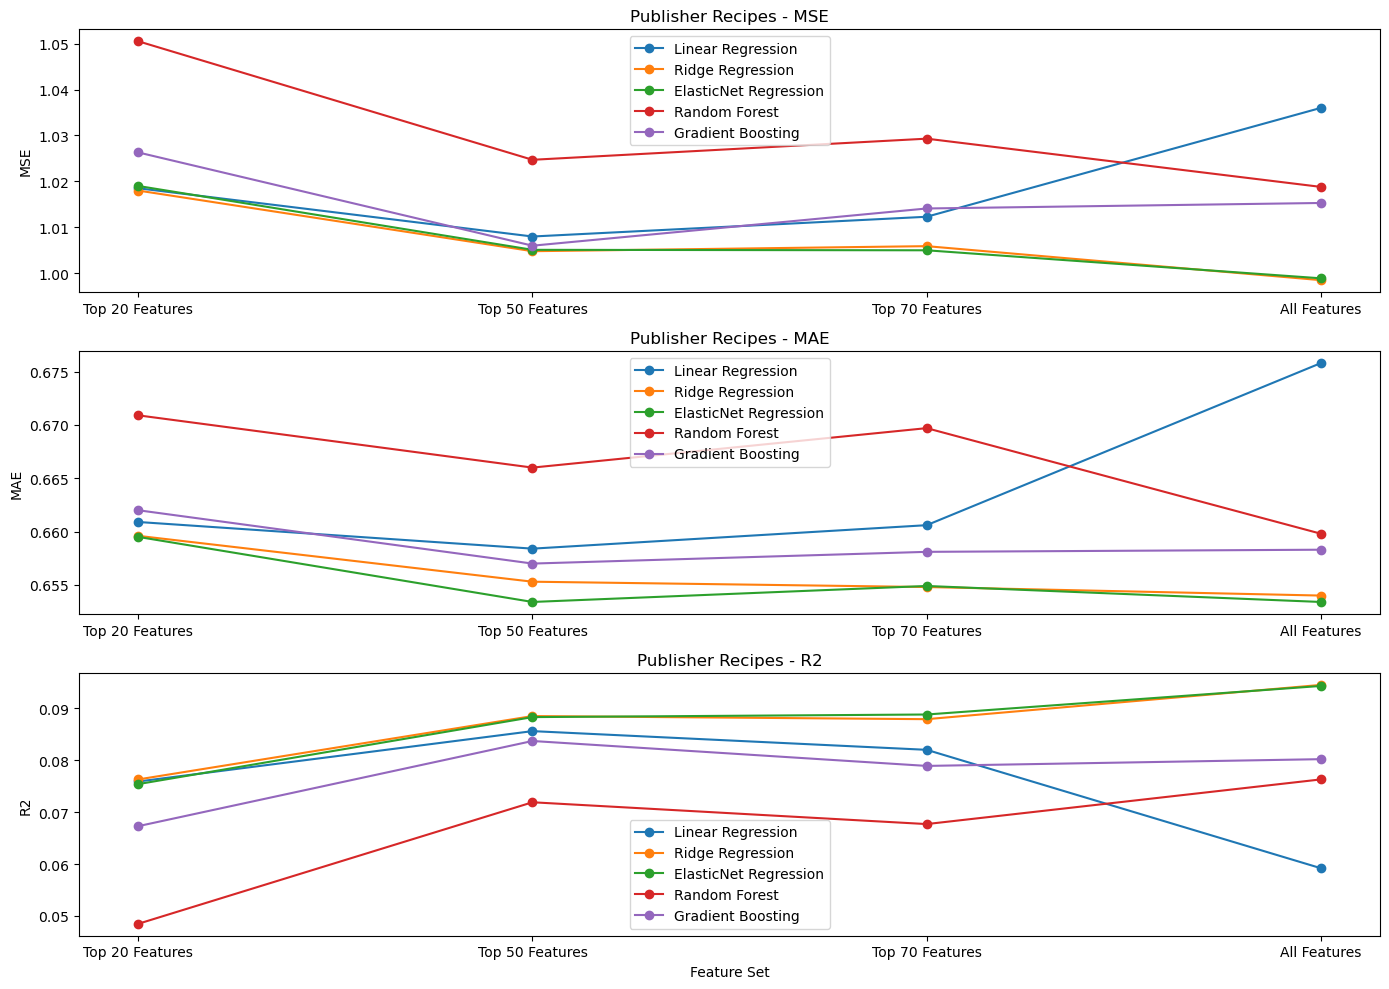

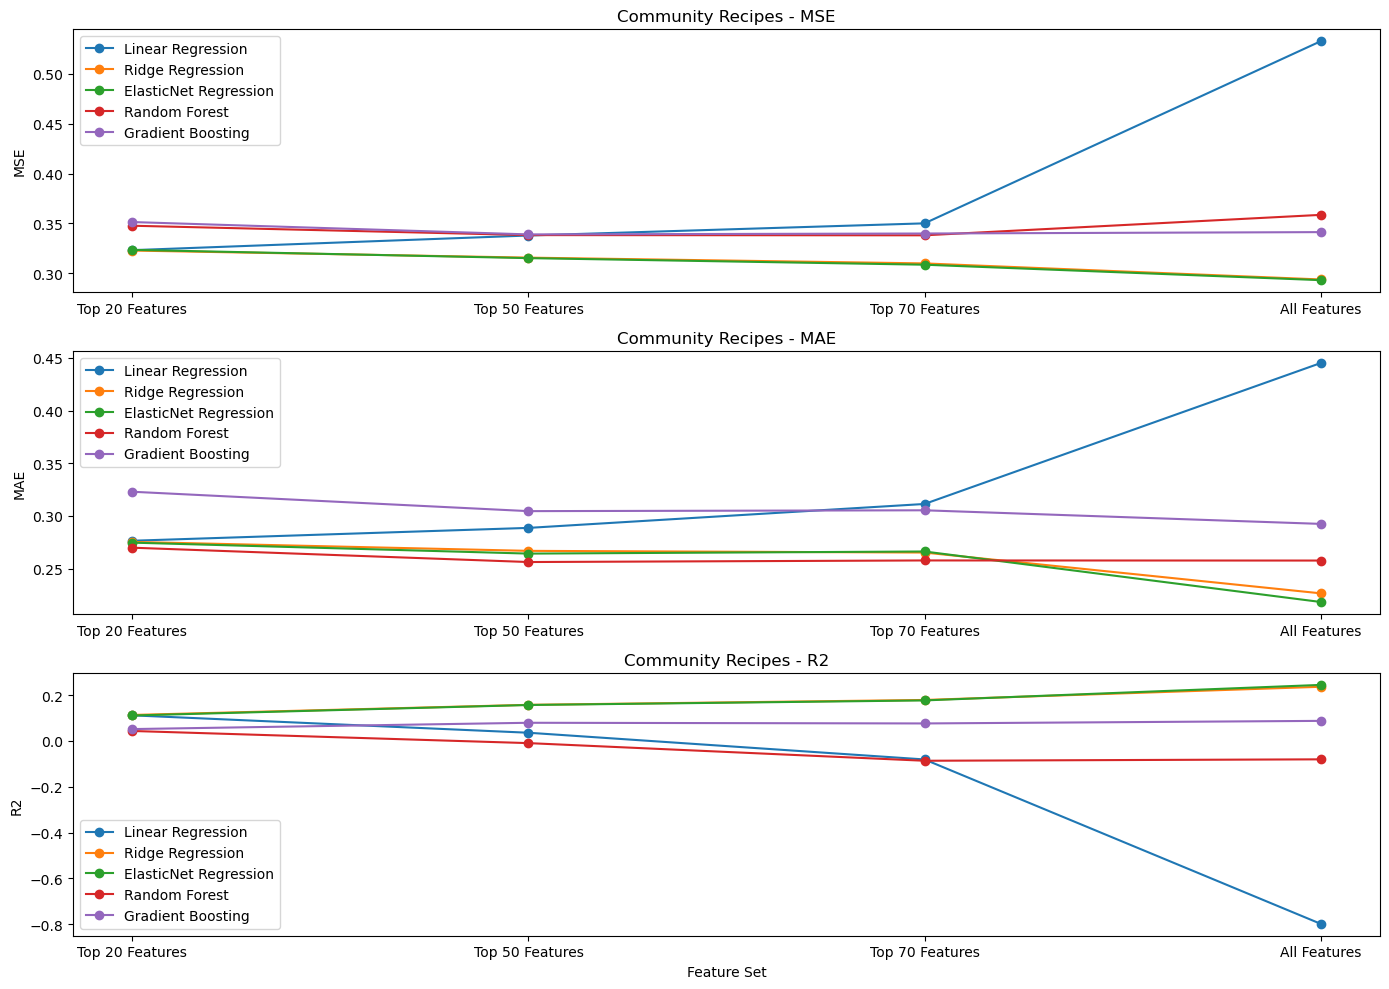

In [46]:
# Function to plot the results
def plot_results(results, title):
    feature_sets = list(results.keys())
    models = list(results[feature_sets[0]].keys())

    # Prepare data for plotting
    mse_data = {model: [results[fs][model]['MSE'] for fs in feature_sets] for model in models}
    mae_data = {model: [results[fs][model]['MAE'] for fs in feature_sets] for model in models}
    r2_data = {model: [results[fs][model]['R2'] for fs in feature_sets] for model in models}

    plt.figure(figsize=(14, 10))

    # MSE Plot
    plt.subplot(3, 1, 1)
    for model, mse_scores in mse_data.items():
        plt.plot(feature_sets, mse_scores, label=model, marker='o')
    plt.title(f'{title} - MSE')
    plt.ylabel('MSE')
    plt.legend()

    # MAE Plot
    plt.subplot(3, 1, 2)
    for model, mae_scores in mae_data.items():
        plt.plot(feature_sets, mae_scores, label=model, marker='o')
    plt.title(f'{title} - MAE')
    plt.ylabel('MAE')
    plt.legend()

    # R2 Plot
    plt.subplot(3, 1, 3)
    for model, r2_scores in r2_data.items():
        plt.plot(feature_sets, r2_scores, label=model, marker='o')
    plt.title(f'{title} - R2')
    plt.ylabel('R2')
    plt.xlabel('Feature Set')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the results for Publisher Recipes
plot_results(publisher_results, 'Publisher Recipes')

# Plot the results for Community Recipes
plot_results(community_results, 'Community Recipes')

### Learnings from Baseline Models Evaluation:

#### Publisher Recipes:
For publisher recipes, the results across different feature sets reveal a few key insights:
- **Ridge Regression and ElasticNet Regression** consistently outperformed other models in terms of R-squared (R2) values, indicating a better fit and higher explanatory power. This suggests that regularization, which both Ridge and ElasticNet apply, is beneficial when working with potentially correlated features in this dataset.
- **Linear Regression** showed relatively stable performance across all feature sets, but its R2 values were lower compared to Ridge and ElasticNet, indicating that it may not be capturing the relationships in the data as effectively without regularization.
- **Random Forest** and **Gradient Boosting** performed slightly worse than the linear models with regularization in terms of MSE and R2 scores, which could be due to the complexity of these models and potential overfitting given the dataset size and feature set used. However, their ability to handle non-linear relationships suggests that further tuning could improve their performance.

#### Community Recipes:
For community recipes, the results varied more significantly across the different feature sets:
- **Ridge Regression and ElasticNet Regression** again showed the strongest performance, particularly in the "All Features" and "Top 70 Features" sets, where they achieved the highest R2 values. This underscores the importance of regularization when dealing with community-generated data, which may have more variability and noise.
- **Linear Regression** performed decently on smaller feature sets like "Top 20 Features" but struggled with the full feature set, indicating that the model might suffer from overfitting when too many features are included without regularization.
- **Random Forest** and **Gradient Boosting** displayed inconsistent performance, particularly with negative R2 scores in some feature sets, suggesting potential overfitting or difficulty in capturing the complex relationships within the community data. These models might benefit from more sophisticated feature selection or hyperparameter tuning to improve their generalization.

The baseline model evaluations indicate that **Ridge Regression** and **ElasticNet Regression** are robust choices for both publisher and community recipe datasets, consistently delivering higher R2 values and lower MSE scores. These models' regularization capabilities help manage the complexity and potential multicollinearity within the feature sets. While **Random Forest** and **Gradient Boosting** models offer potential for capturing non-linear patterns, their performance suggests a need for further tuning or alternative feature engineering approaches to optimize their predictive accuracy in this context.

## 6. Neural Networks

This chapter delves into the application of various neural network architectures for predicting recipe popularity, exploring their effectiveness in capturing complex patterns within the data. The chapter begins with **Simple Neural Networks (SimpleNNs)**, which provide a foundational understanding of neural network performance on the dataset. These basic models serve as a baseline, highlighting how standard feedforward, recurrent, and long short-term memory (LSTM) networks perform when applied to the task at hand.

Building upon the insights gained from SimpleNNs, the chapter then progresses to **Deep Neural Networks (DNNs)**. These networks, with their multiple hidden layers, are designed to capture more intricate relationships in the data, offering enhanced predictive capabilities. The complexity of DNNs could allow for a deeper understanding of the factors influencing recipe popularity, especially when dealing with a larger and more complex feature space.

Finally, the chapter introduces **Transformer-Based Neural Networks**, a state-of-the-art architecture in handling sequential data and capturing long-range dependencies. This section explores how transformer models, leveraging their attention mechanisms, handle natural language processing and complex pattern recognition.

### 6.1 Simple Neural Networks

In [ ]:
# Define the SimpleNN class for the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the SimpleLSTM class for LSTM neural network
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), 128).to(x.device)
        c_0 = torch.zeros(1, x.size(0), 128).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

# Define the SimpleRNN class for RNN neural network
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), 128).to(x.device)
        out, _ = self.rnn(x, h_0)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Function to evaluate the neural network
def evaluate_nn(model, criterion, dataloader, y_true):
    # Set the model to evaluation mode
    model.eval()
    mse = 0.0  # Initialize the Mean Squared Error accumulator
    all_outputs = []  # List to store all model predictions

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, targets in dataloader:
            # Get the model predictions
            outputs = model(inputs)
            # Calculate the loss (MSE)
            loss = criterion(outputs, targets)
            mse += loss.item() * inputs.size(0)
            all_outputs.extend(outputs.numpy().flatten())
    # Calculate the average MSE over the entire dataset
    mse /= len(dataloader.dataset)

    y_pred = pd.Series(all_outputs)
    # Calculate the Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    # Calculate the R-squared score (R2)
    r2 = r2_score(y_true, y_pred)

    return mse, mae, r2

# Cross-validation function for the neural network with result aggregation
def cross_validate_nn(X, y, model_type='nn', epochs=10, batch_size=32, n_splits=5, save_path=None):
    # Initialize K-Fold cross-validation with the specified number of splits
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Lists to store metrics across all folds
    fold_mse = []
    fold_mae = []
    fold_r2 = []

    best_mse = float('inf')
    best_model = None

    # Iterate through each fold (train/test split)
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        # Split the data into training and testing sets based on the current fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Run the neural network experiment and get the evaluation metrics
        mse, mae, r2, model = run_nn_experiment(X_train, y_train, X_test, y_test, model_type, epochs, batch_size)
        fold_mse.append(mse)
        fold_mae.append(mae)
        fold_r2.append(r2)

        # Check if this is the best model so far based on MSE
        if mse < best_mse:
            best_mse = mse
            best_model = model

    # Save the best model
    if save_path and best_model:
        model_filename = os.path.join(save_path, f'simple_{model_type}_best.pth')
        torch.save(best_model.state_dict(), model_filename)

    print(f'\n{model_type.upper()} - Cross-Validation results: MSE: {np.mean(fold_mse):.4f}, MAE: {np.mean(fold_mae):.4f}, R2: {np.mean(fold_r2):.4f}')
    return np.mean(fold_mse), np.mean(fold_mae), np.mean(fold_r2)

In [49]:
# Function to run the neural network experiment for all model types
def run_nn_experiment(X_train, y_train, X_test, y_test, model_type='nn', epochs=10, batch_size=32):
    # Convert data to numpy arrays if they are not already
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    # For RNN/LSTM, reshape the data to have an additional dimension
    if model_type in ['rnn', 'lstm']:
        X_train_tensor = X_train_tensor.view(X_train_tensor.size(0), 1, -1)
        X_test_tensor = X_test_tensor.view(X_test_tensor.size(0), 1, -1)

    input_size = X_train_tensor.shape[-1]

    # Initialize the appropriate model
    if model_type == 'nn':
        model = SimpleNN(input_size)
    elif model_type == 'rnn':
        model = SimpleRNN(input_size)
    elif model_type == 'lstm':
        model = SimpleLSTM(input_size)
    else:
        raise ValueError("Invalid model type")

    # Define the loss function (Mean Squared Error) and the optimizer (Adam)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Create TensorDataset and DataLoader for both training and testing sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training loop for the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        train_mse, train_mae, train_r2 = evaluate_nn(model, criterion, train_loader, y_train)
        test_mse, test_mae, test_r2 = evaluate_nn(model, criterion, test_loader, y_test)

    return test_mse, test_mae, test_r2, model

In [ ]:
# Paths to save the models
publisher_save_path = "best_models/publisher"
community_save_path = "best_models/community"

# Create directories if they do not exist
os.makedirs(publisher_save_path, exist_ok=True)
os.makedirs(community_save_path, exist_ok=True)

# Cross-validation for each model type using all features
for model_type in ['nn', 'rnn', 'lstm']:
    print(f"\nCross-validating {model_type.upper()} on All Features for Publisher Recipes:")
    cross_validate_nn(X_pub, y_pub, model_type=model_type, save_path=publisher_save_path)

    print(f"\nCross-validating {model_type.upper()} on All Features for Community Recipes:")
    cross_validate_nn(X_comm, y_comm, model_type=model_type, save_path=community_save_path)

# Cross-validation for each model type using all features
for model_type in ['nn', 'rnn', 'lstm']:
    print(f"\nCross-validating {model_type.upper()} on All Features for Publisher Recipes:")
    cross_validate_nn(X_pub, y_pub, model_type=model_type)

    print(f"\nCross-validating {model_type.upper()} on All Features for Community Recipes:")
    cross_validate_nn(X_comm, y_comm, model_type=model_type)


Cross-validating NN on All Features for Publisher Recipes:

NN - Cross-Validation results: MSE: 1.0189, MAE: 0.6606, R2: 0.0692

Cross-validating NN on All Features for Community Recipes:

NN - Cross-Validation results: MSE: 0.5351, MAE: 0.4526, R2: 0.0861

Cross-validating RNN on All Features for Publisher Recipes:

RNN - Cross-Validation results: MSE: 0.9738, MAE: 0.6444, R2: 0.1160

Cross-validating RNN on All Features for Community Recipes:

RNN - Cross-Validation results: MSE: 0.4917, MAE: 0.4304, R2: 0.1647

Cross-validating LSTM on All Features for Publisher Recipes:

LSTM - Cross-Validation results: MSE: 0.9465, MAE: 0.6460, R2: 0.1407

Cross-validating LSTM on All Features for Community Recipes:

LSTM - Cross-Validation results: MSE: 0.4853, MAE: 0.4221, R2: 0.1755


### **Learnings from Simple Neural Networks Evaluation**

- **Publisher Recipes:** The performance of simple neural networks (NNs), RNNs, and LSTMs on the Publisher recipes dataset revealed a consistent trend where RNNs and LSTMs slightly outperformed traditional NNs. The LSTM model achieved the lowest MSE of `0.9465` and the highest R2 score of `0.1407`, indicating that it could better capture the underlying patterns in the data compared to other models. However, despite these relatively better metrics, the R2 scores still suggest that all models faced challenges in generalizing well to the dataset.

- **Community Recipes:** The Community recipes dataset exhibited a similar trend, where LSTM models again showed superior performance compared to NNs and RNNs. The LSTM model produced the lowest MSE of `0.4853` and the highest R2 score of `0.1755`. The positive R2 scores across all models suggest a better fit to the Community recipes data compared to the Publisher recipes data, indicating that the models were more effective in capturing the relationships within this dataset.

Overall, the evaluation suggests that for both datasets, models capable of handling sequential dependencies, such as LSTMs and RNNs, provide better performance and generalization compared to traditional NNs, especially when all features are utilized.

### 6.2 Deep Neural Networks

The approach to implementing **deep neural networks** is centered around enhancing the predictive accuracy for recipe popularity by leveraging **advanced architectures** and systematic **hyperparameter tuning**. 

Three different types of models—**AdvancedNN**, **AdvancedLSTM**, and **AdvancedRNN**—are constructed with multiple layers, incorporating techniques such as **batch normalization** and **dropout** to prevent overfitting. The models are trained using a **cross-validation** approach to ensure they generalize well across unseen data. **Hyperparameters** like **learning rate**, **batch size**, **dropout rate**, the number of **hidden layers**, and **feature size** were fine-tuned using **random search**. By varying the **feature size**, the models are trained on different subsets of features, ranging from a small set of the most relevant features to the entire feature set. 

This approach was applied separately to **publisher** and **community recipe datasets**, ensuring that the models were tailored to the specific characteristics of each data subset.

In [ ]:
# Define the AdvancedNN class for the neural network
class AdvancedNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate):
        super(AdvancedNN, self).__init__()
        layers = []
        for i, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(input_size if i == 0 else hidden_sizes[i-1], hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.model(x)
        return x.view(-1, 1)

# Define the AdvancedLSTM class for the neural network
class AdvancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout_rate=0.5):
        super(AdvancedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out.view(-1, 1)

# Define the AdvancedRNN class for the neural network
class AdvancedRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout_rate=0.5):
        super(AdvancedRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_size = hidden_size

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        h_0 = torch.zeros(self.rnn.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h_0)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out.view(-1, 1)

In [ ]:
# Function to evaluate the model's performance on the test set
def evaluate_nn(model, criterion, dataloader, y_true, model_type):
    model.eval() # Set the model to evaluation mode
    mse = 0.0
    all_outputs = []
    with torch.no_grad(): # Disable gradient calculation
        for inputs, targets in dataloader:
            # Adjust input dimensions for RNN or LSTM models
            if model_type in ['rnn', 'lstm']:
                if len(inputs.shape) == 2:
                    inputs = inputs.view(inputs.size(0), 1, -1)
            # Get model predictions
            outputs = model(inputs)
            outputs = outputs.view(-1, 1)  # Ensure the output size matches the target size
            # Calculate loss
            loss = criterion(outputs, targets)
            mse += loss.item() * inputs.size(0)
            all_outputs.extend(outputs.cpu().numpy().flatten())
    mse /= len(dataloader.dataset)
    # Calculate MAE and R2 score
    y_pred = pd.Series(all_outputs)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

In [ ]:
# Function to run training and evaluation for a specific neural network model
def run_nn_experiment(X_train, y_train, X_test, y_test, model_type='nn', hidden_sizes=[128, 64], dropout_rate=0.5, epochs=10, batch_size=32, learning_rate=0.001):
    # Convert data to tensors if they are in DataFrame format
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    # Adjust input dimensions for RNN or LSTM models
    if model_type in ['rnn', 'lstm']:
        X_train_tensor = X_train_tensor.view(X_train_tensor.size(0), 1, -1)
        X_test_tensor = X_test_tensor.view(X_test_tensor.size(0), 1, -1)

    input_size = X_train_tensor.shape[-1]

    # Instantiate the appropriate model based on the type
    if model_type == 'nn':
        model = AdvancedNN(input_size, hidden_sizes, dropout_rate)
    elif model_type == 'rnn':
        model = AdvancedRNN(input_size, hidden_size=hidden_sizes[0], dropout_rate=dropout_rate)
    elif model_type == 'lstm':
        model = AdvancedLSTM(input_size, hidden_size=hidden_sizes[0], dropout_rate=dropout_rate)
    else:
        raise ValueError("Invalid model type")

    criterion = nn.MSELoss() # Mean Squared Error loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer

    # Create DataLoader objects for training and test sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    for epoch in range(epochs):
        model.train() # Set the model to training mode
        for inputs, targets in train_loader:
            optimizer.zero_grad() # Clear previous gradients
            outputs = model(inputs)
            outputs = outputs.squeeze(-1)  # Ensure the output size matches the target size
            loss = criterion(outputs, targets)
            loss.backward() # Backpropagation
            optimizer.step() # Update weights

        # Evaluate the model on the training and test sets after each epoch
        train_mse, train_mae, train_r2 = evaluate_nn(model, criterion, train_loader, y_train, model_type)
        test_mse, test_mae, test_r2 = evaluate_nn(model, criterion, test_loader, y_test, model_type)

    return model, test_mse

In [ ]:
# Cross-validation function for the neural network
def cross_validate_nn(X, y, model_type='nn', hidden_sizes=[128, 64], dropout_rate=0.5, epochs=10, batch_size=32, n_splits=5, learning_rate=0.001):
    # Initialize K-Fold cross-validation with n_splits, shuffling the data, and setting a random seed for reproducibility
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Lists to store performance metrics for each fold
    fold_mse = []
    fold_mae = []
    fold_r2 = []
    
    best_model = None  # Variable to store the best model based on MSE
    best_mse = float('inf')  # Initialize the best MSE to a very large number

    fold = 1  # Counter for folds
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets for the current fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model and evaluate it on the test set
        model, test_mse = run_nn_experiment(X_train, y_train, X_test, y_test, model_type, hidden_sizes, dropout_rate, epochs, batch_size, learning_rate)

        # Store the evaluation metrics for this fold
        fold_mse.append(test_mse)
        fold_mae.append(mean_absolute_error(y_test, model(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy()))
        fold_r2.append(r2_score(y_test, model(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy()))

        # Check if the current model is the best so far based on MSE
        if test_mse < best_mse:
            best_mse = test_mse
            best_model = model  # Update the best model

        fold += 1  # Move to the next fold

    # Print the average performance metrics across all folds
    print(f'\n{model_type.upper()} - Cross-Validation results: MSE: {np.mean(fold_mse):.4f}, MAE: {np.mean(fold_mae):.4f}, R2: {np.mean(fold_r2):.4f}')
    
    # Return the average metrics and the best model
    return np.mean(fold_mse), np.mean(fold_mae), np.mean(fold_r2), best_model

In [ ]:
def random_search_nn(X, y, model_type, param_grid, num_searches=10, save_path='./best_models', dataset_type='publisher'):
    best_params = None
    best_score = float('inf')
    best_model = None

    # Ensure the save_path includes the dataset type (publisher or community)
    save_path = os.path.join(save_path, dataset_type)

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for i in range(num_searches):
        params = {
            'hidden_sizes': [int(np.random.choice(param_grid['hidden_sizes'])) for _ in range(len(param_grid['hidden_sizes']))],
            'dropout_rate': np.random.choice(param_grid['dropout_rate']),
            'epochs': np.random.choice(param_grid['epochs']),
            'batch_size': int(np.random.choice(param_grid['batch_size'])),
            'learning_rate': np.random.choice(param_grid['learning_rate']),
        }

        # Select the top features based on the selected feature size
        num_features = np.random.choice(param_grid['feature_size'])
        X_selected = get_top_features(X, y, num_features)

        print(f"\nSearch {i + 1}/{num_searches}: Evaluating {model_type.upper()} with params: {params} and top {num_features} features")

        # Pass the correct parameters to cross_validate_nn
        mse, mae, r2, model = cross_validate_nn(X_selected, y, model_type=model_type, **params)

        if mse < best_score:
            best_score = mse
            best_params = params
            best_model = model
            # Save the best model so far
            model_filename = f"deep_{model_type}_best_{num_features}.pth"
            model_path = os.path.join(save_path, model_filename)
            torch.save(best_model.state_dict(), model_path)

    print(f"\nBest parameters found for {model_type.upper()}: {best_params} with MSE: {best_score:.4f}")
    return best_params, best_model

In [ ]:
def get_top_features(X, y, num_features):
    if num_features == 'all':
        return X  # Return all features if 'all' is selected
    else:
        # Ensure num_features is an integer
        num_features = int(num_features)
        # Calculate correlation with the target variable
        corrs = X.corrwith(y).abs().sort_values(ascending=False)
        top_features = corrs.head(num_features).index.tolist()
        return X[top_features]

# Parameter Grid for random search
param_grid = {
    'hidden_sizes': [32, 64, 256],
    'dropout_rate': [0.3, 0.4, 0.5],
    'epochs': [5, 10, 20],
    'batch_size': [16, 32],
    'learning_rate': [0.01, 0.001],
    'feature_size': [20, 50, 70, 'all'],
}

# Perform random search on publisher recipes with different models and feature sizes
print("Performing random search on Publisher Recipes with different models:")
best_params_pub_nn, best_model_pub_nn = random_search_nn(X_pub, y_pub, model_type='nn', param_grid=param_grid, num_searches=5, save_path='./best_models', dataset_type='publisher')
best_params_pub_rnn, best_model_pub_rnn = random_search_nn(X_pub, y_pub, model_type='rnn', param_grid=param_grid, num_searches=5, save_path='./best_models', dataset_type='publisher')
best_params_pub_lstm, best_model_pub_lstm = random_search_nn(X_pub, y_pub, model_type='lstm', param_grid=param_grid, num_searches=5, save_path='./best_models', dataset_type='publisher')

# Perform random search on community recipes with different models and feature sizes
print("\nPerforming random search on Community Recipes with different models:")
best_params_comm_nn, best_model_comm_nn = random_search_nn(X_comm, y_comm, model_type='nn', param_grid=param_grid, num_searches=5, save_path='./best_models', dataset_type='community')
best_params_comm_rnn, best_model_comm_rnn = random_search_nn(X_comm, y_comm, model_type='rnn', param_grid=param_grid, num_searches=5, save_path='./best_models', dataset_type='community')
best_params_comm_lstm, best_model_comm_lstm = random_search_nn(X_comm, y_comm, model_type='lstm', param_grid=param_grid, num_searches=5, save_path='./best_models', dataset_type='community')

Performing random search on Publisher Recipes with different models:

Search 1/5: Evaluating NN with params: {'hidden_sizes': [64, 256, 32], 'dropout_rate': 0.5, 'epochs': 5, 'batch_size': 16, 'learning_rate': 0.01} and top 20 features

NN - Cross-Validation results: MSE: 1.1038, MAE: 0.7000, R2: -0.0015

Search 2/5: Evaluating NN with params: {'hidden_sizes': [64, 64, 32], 'dropout_rate': 0.4, 'epochs': 20, 'batch_size': 16, 'learning_rate': 0.01} and top all features

NN - Cross-Validation results: MSE: 1.1043, MAE: 0.6974, R2: -0.0019

Search 3/5: Evaluating NN with params: {'hidden_sizes': [64, 64, 256], 'dropout_rate': 0.5, 'epochs': 20, 'batch_size': 16, 'learning_rate': 0.01} and top all features

NN - Cross-Validation results: MSE: 1.1047, MAE: 0.6978, R2: -0.0024

Search 4/5: Evaluating NN with params: {'hidden_sizes': [64, 256, 32], 'dropout_rate': 0.4, 'epochs': 5, 'batch_size': 16, 'learning_rate': 0.001} and top 20 features

NN - Cross-Validation results: MSE: 1.1050, MAE:

### **Learnings from Deep Neural Networks Evaluation:**

#### **Publisher Recipes**

- **Performance Summary:** The Publisher recipes dataset showed that LSTM models consistently outperformed other architectures, though the overall performance metrics, such as MSE and R2, indicated room for improvement. Despite the LSTM models achieving the lowest MSE of `1.0945`, the R2 scores hovered around 0, reflecting challenges in achieving consistent generalization across the dataset.

- **Promising Results:** The LSTM configuration with a learning rate of `0.001`, dropout rate of `0.3`, and `10` epochs emerged as the most effective setup for the Publisher recipes. This model managed to strike a balance between overfitting and underfitting, as seen in the comparatively better performance metrics. 

- **Feature Size Impact:** The evaluation showed that using more features did not always lead to better performance. Specifically, configurations that utilized the top 20 features often performed similarly or better than those using all available features, suggesting that more features might introduce noise and complexity rather than improving model accuracy. This highlights the importance of feature selection and dimensionality reduction in optimizing model performance.

#### **Community Recipes**

- **Performance Summary:** The Community recipes dataset saw both RNN and LSTM models performing well, with MSE values close to `0.3678`. However, similar to the Publisher recipes, the R2 scores were still negative or close to zero, indicating difficulties in achieving robust predictive power. Despite these challenges, the models showed more promise with this dataset, particularly under specific configurations.

- **Promising Results:** The best results were achieved by an RNN model with a learning rate of `0.001`, dropout rate of `0.4`, and `20` epochs. This model configuration produced the lowest MSE and the highest R2 among the tested setups, indicating a relatively better fit to the data. 

- **Feature Size Impact:** Similar to the Publisher recipes, increasing the number of features did not consistently improve performance. The models using a selected set of top features often outperformed those with a larger number of features, indicating that the Community recipes dataset also benefits from careful feature selection. Reducing the feature set helped in maintaining the model's focus on the most relevant data, thus enhancing generalization and reducing overfitting.

In [ ]:
# Data for Publisher Recipes
publisher_results = {
    'SimpleNN': {'MSE': 1.0189, 'MAE': 0.6606, 'R2': 0.0692},
    'SimpleRNN': {'MSE': 0.9738, 'MAE': 0.6444, 'R2': 0.1160},
    'SimpleLSTM': {'MSE': 0.9465, 'MAE': 0.6460, 'R2': 0.1407},
    'AdvNN': {'MSE': 1.1034, 'MAE': 0.7028, 'R2': -0.0012},
    'AdvRNN': {'MSE': 1.0996, 'MAE': 0.6943, 'R2': 0.0024},
    'AdvLSTM': {'MSE': 1.0945, 'MAE': 0.6964, 'R2': 0.0070}
}

# Data for Community Recipes
community_results = {
    'SimpleNN': {'MSE': 0.5351, 'MAE': 0.4526, 'R2': 0.0861},
    'SimpleRNN': {'MSE': 0.4917, 'MAE': 0.4304, 'R2': 0.1647},
    'SimpleLSTM': {'MSE': 0.4853, 'MAE': 0.4221, 'R2': 0.1755},
    'AdvNN': {'MSE': 0.3712, 'MAE': 0.3563, 'R2': -0.0245},
    'AdvRNN': {'MSE': 0.3678, 'MAE': 0.3493, 'R2': -0.0084},
    'AdvLSTM': {'MSE': 0.3678, 'MAE': 0.3505, 'R2': -0.0021}
}

# Extracting data for plotting
models = list(publisher_results.keys())
publisher_mse = [publisher_results[model]['MSE'] for model in models]
publisher_mae = [publisher_results[model]['MAE'] for model in models]
publisher_r2 = [publisher_results[model]['R2'] for model in models]

community_mse = [community_results[model]['MSE'] for model in models]
community_mae = [community_results[model]['MAE'] for model in models]
community_r2 = [community_results[model]['R2'] for model in models]

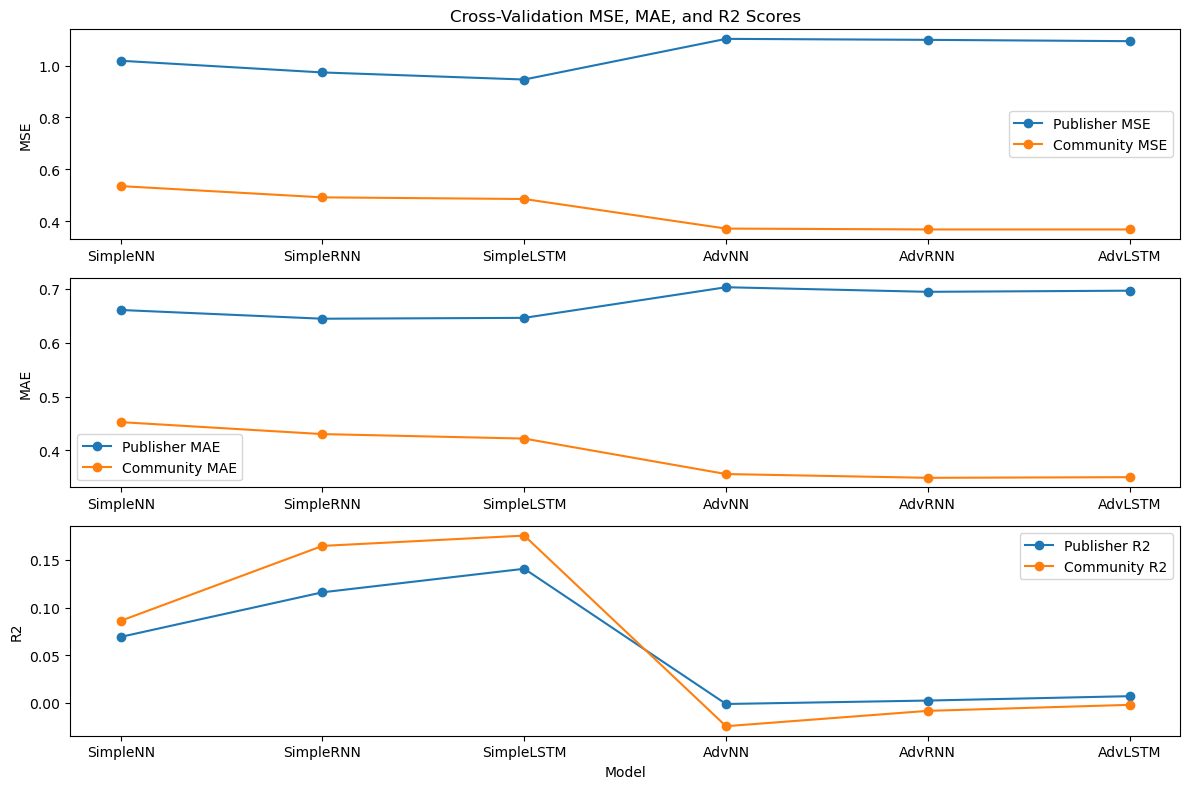

In [56]:
# Plotting the results
plt.figure(figsize=(12, 8))

# MSE Plot
plt.subplot(3, 1, 1)
plt.plot(models, publisher_mse, label='Publisher MSE', marker='o')
plt.plot(models, community_mse, label='Community MSE', marker='o')
plt.title('Cross-Validation MSE, MAE, and R2 Scores')
plt.ylabel('MSE')
plt.legend()

# MAE Plot
plt.subplot(3, 1, 2)
plt.plot(models, publisher_mae, label='Publisher MAE', marker='o')
plt.plot(models, community_mae, label='Community MAE', marker='o')
plt.ylabel('MAE')
plt.legend()

# R2 Plot
plt.subplot(3, 1, 3)
plt.plot(models, publisher_r2, label='Publisher R2', marker='o')
plt.plot(models, community_r2, label='Community R2', marker='o')
plt.ylabel('R2')
plt.xlabel('Model')
plt.legend()

plt.tight_layout()
plt.show()

### Learnings from Neural Network Models Evaluation:

#### Publisher Recipes:
The evaluation of neural network models on publisher recipes reveals several important observations:
- **SimpleLSTM** consistently outperformed other neural network architectures, including SimpleNN and SimpleRNN, achieving the best MSE and R2 scores across the board. This suggests that LSTM’s ability to capture sequential dependencies and long-term patterns in text data, such as recipe instructions, is particularly valuable in this context.
- **SimpleRNN** also performed reasonably well, especially when compared to the fully connected SimpleNN model. However, it lagged behind LSTM, indicating that while RNNs can handle sequence data, they may not capture long-term dependencies as effectively as LSTMs.
- The performance of the **deeper neural networks (NN, RNN, LSTM)** with random search hyperparameter tuning was generally poorer compared to their simpler counterparts. Despite using more advanced architectures, the results suggest that these models might be overfitting or struggling with the complexity of the dataset, as evidenced by the marginal improvements in MSE and the low R2 scores. The **LSTM** model did show slight improvements over NN and RNN but still didn’t surpass the performance of the simple models by a large margin, indicating potential issues with model complexity or training stability.

#### Community Recipes:
For community recipes, the neural network models exhibited more variability in performance:
- **SimpleLSTM** again proved to be the best-performing model among the tested architectures, achieving the lowest MSE and highest R2 scores. This underscores LSTM's strength in handling the temporal and sequential nature of text data, which is crucial for understanding the nuances in community-generated content.
- **SimpleRNN** performed better than SimpleNN but did not match the effectiveness of LSTM, reflecting similar trends observed in the publisher dataset. The need for capturing long-term dependencies is apparent in community recipes, where variability in content might be higher.
- The deeper, tuned **NN, RNN, and LSTM models** struggled with performance, particularly the NN model, which showed a significant drop in R2 scores. The higher MSE scores and lower R2 values indicate that these models might have overfitted the training data or encountered issues with the more complex optimization landscape. Despite fine-tuning, the improvements were minimal, and the models did not generalize well to the validation data.

### Conclusion:
The evaluation of neural network models on both publisher and community recipes highlights that among the neural networks **SimpleLSTM** is the most effective architecture for this specific task. Its ability to capture sequential dependencies in the data allows it to outperform both fully connected and simpler RNN models. However, the deeper, more complex models with extensive hyperparameter tuning did not yield the expected performance gains, suggesting that simpler models may be more robust and easier to train in this context. **SimpleLSTM** offers a good balance between complexity and performance, making it a strong candidate for further refinement and application to similar tasks involving text data with temporal or sequential dependencies.

### 6.3 BERT: Transformer-based neural network

The BERT-based approach focuses on leveraging the language capabilities of the **BERT model** combined with additional numerical features to predict recipe popularity. This approach integrates **textual data** (such as recipe titles, ingredients, and preparation steps) with **numerical data** (like cooking times and nutritional values) to create a comprehensive model. 

A custom **RecipeDatasetWithNumerical** class is designed to handle this combined input, ensuring that both textual and numerical features are appropriately processed and fed into the model. The **BERTRegressorWithNumerical** model architecture then combines the BERT output with the processed numerical features, allowing the model to capture both the complex linguistic patterns in the recipe text and the structured data from numerical inputs.

The training process employs a **cross-validation** strategy, ensuring that the model's performance is consistent across different subsets of data. Additionally, **hyperparameters** such as learning rate, batch size, dropout rate, and maximum token length were fine-tuned using a **random search** methodology. This allows the exploration of various configurations to identify the best-performing model. 

In [ ]:
# Training and evaluation functions
def train_epoch(model, data_loader, loss_fn, optimizer, device, epoch):
    model.train()
    losses = []

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        numerical_features = d['numerical_features'].to(device)
        targets = d['targets'].to(device).view(-1, 1)  # Reshape targets to [batch_size, 1]

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, numerical_features=numerical_features)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    print(f"Epoch {epoch + 1} - Training Loss: {np.mean(losses):.4f}")
    return np.mean(losses)

def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    preds = []
    actuals = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            numerical_features = d['numerical_features'].to(device)
            targets = d['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, numerical_features=numerical_features)
            loss = loss_fn(outputs, targets.view(-1, 1))
            losses.append(loss.item())

            preds.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    preds = np.array(preds).flatten()
    actuals = np.array(actuals).flatten()

    mse = mean_squared_error(actuals, preds)
    mae = mean_absolute_error(actuals, preds)
    r2 = r2_score(actuals, preds)

    return mse, mae, r2

In [58]:
# Custom Dataset class for BERT with numerical features
class RecipeDatasetWithNumerical(torch.utils.data.Dataset):
    def __init__(self, texts, numerical_features, targets, tokenizer, max_len):
        self.texts = texts
        self.numerical_features = numerical_features
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        numerical_features = self.numerical_features.iloc[index].values
        target = self.targets[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'numerical_features': torch.tensor(numerical_features, dtype=torch.float),
            'targets': torch.tensor(target, dtype=torch.float)
        }

# Model combining BERT with numerical features
class BERTRegressorWithNumerical(nn.Module):
    def __init__(self, num_numerical_features, dropout=0.3):
        super(BERTRegressorWithNumerical, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=dropout)
        self.fc_numerical = nn.Linear(num_numerical_features, 32)
        self.fc_combined = nn.Linear(self.bert.config.hidden_size + 32, 1)

    def forward(self, input_ids, attention_mask, numerical_features):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        bert_output = outputs.pooler_output
        bert_output = self.drop(bert_output)

        numerical_output = torch.relu(self.fc_numerical(numerical_features))
        combined_output = torch.cat((bert_output, numerical_output), dim=1)
        return self.fc_combined(combined_output)

In [ ]:
# Function to train and evaluate a model, saving the best model during training
def cross_val_train(X_text, X_num, y, params, save_dir, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    kf = KFold(n_splits=5)
    fold_mse = []
    fold_mae = []
    fold_r2 = []

    best_mse = float('inf')
    best_model_state = None

    for fold, (train_index, val_index) in enumerate(kf.split(X_text)):
        print(f"\nFold {fold + 1}: ")
        X_train_text, X_val_text = X_text.iloc[train_index].reset_index(drop=True), X_text.iloc[val_index].reset_index(drop=True)
        X_train_num, X_val_num = X_num.iloc[train_index].reset_index(drop=True), X_num.iloc[val_index].reset_index(drop=True)
        y_train, y_val = y.iloc[train_index].reset_index(drop=True), y.iloc[val_index].reset_index(drop=True)

        train_dataset = RecipeDatasetWithNumerical(texts=X_train_text, numerical_features=X_train_num, targets=y_train, tokenizer=tokenizer, max_len=params['max_len'])
        val_dataset = RecipeDatasetWithNumerical(texts=X_val_text, numerical_features=X_val_num, targets=y_val, tokenizer=tokenizer, max_len=params['max_len'])

        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

        model = BERTRegressorWithNumerical(num_numerical_features=X_num.shape[1], dropout=params['dropout_rate']).to(device)
        loss_fn = nn.MSELoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        for epoch in range(params['num_epochs']):
            train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, epoch)
            val_mse, val_mae, val_r2 = eval_model(model, val_loader, loss_fn, device)
            print(f"Epoch {epoch + 1} - Validation MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, R2: {val_r2:.4f}")

            # Save the best model state based on validation MSE
            if val_mse < best_mse:
                best_mse = val_mse
                best_model_state = model.state_dict()

        train_mse, train_mae, train_r2 = eval_model(model, train_loader, loss_fn, device)
        fold_mse.append(val_mse)
        fold_mae.append(val_mae)
        fold_r2.append(val_r2)

    # Save the best model for the current cross-validation fold
    os.makedirs(save_dir, exist_ok=True)
    model_save_path = os.path.join(save_dir, f"{model_name}_fold{fold + 1}.pth")
    torch.save(best_model_state, model_save_path)
    print(f"Best model for fold {fold + 1} saved to {model_save_path}")

    return np.mean(fold_mse), np.mean(fold_mae), np.mean(fold_r2)

In [ ]:
# Function to perform random search and save the best model
def random_search(X_text, X_num, y, param_grid, num_searches, save_dir):
    best_params = None
    best_score = float('inf')

    for i in range(num_searches):
        params = {
            'learning_rate': np.random.choice(param_grid['learning_rate']),
            'batch_size': int(np.random.choice(param_grid['batch_size'])),
            'num_epochs': np.random.choice(param_grid['num_epochs']),
            'dropout_rate': np.random.choice(param_grid['dropout_rate']),
            'max_len': np.random.choice(param_grid['max_len']),
        }

        print(f"\nSearch {i + 1}/{num_searches}: Evaluating with params: {params}")
        mse, mae, r2 = cross_val_train(X_text, X_num, y, params, save_dir, model_name=f"search_{i + 1}")

        print(f"Search {i + 1}/{num_searches} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
        if mse < best_score:
            best_score = mse
            best_params = params

    print(f"\nBest parameters found: {best_params} with MSE: {best_score:.4f}")
    return best_params

In [ ]:
# Preprocessing and tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define the parameter grid for random search
param_grid = {
    'learning_rate': [2e-5, 3e-5, 5e-5],
    'batch_size': [16, 32],
    'num_epochs': [5, 10, 20],
    'dropout_rate': [0.3, 0.4, 0.5],
    'max_len': [128, 256, 450],
}

# Combining text columns
def combine_text_columns(df):
    return df[['Recipe Title', 'Ingredients', 'Preparation Steps', 'Tags', 'Categories']].fillna('').agg(' '.join, axis=1)

In [47]:
# Separate publisher and community recipes
publisher_recipes = df_recipes[df_recipes['Role'] == 0]
community_recipes = df_recipes[df_recipes['Role'] == 1]

# Define features and target
selected_columns = ['Total Time', 'Prep Time', 'Cook Time', 'Number of Steps', 'Number of Ingredients',
                    'Calories', 'Fat', 'Protein', 'Sugar', 'Carbs', 'Fiber']

X_pub_text = combine_text_columns(publisher_recipes)
X_pub_num = publisher_recipes[selected_columns]
y_pub = publisher_recipes['Score'].astype(float)

X_comm_text = combine_text_columns(community_recipes)
X_comm_num = community_recipes[selected_columns]
y_comm = community_recipes['Score'].astype(float)

# Example directory to save models
save_dir_pub = './best_models_publisher'
save_dir_comm = './best_models_community'

# Perform random search on publisher recipes and save the best models
print("Performing random search on Publisher Recipes:")
best_params_pub = random_search(X_pub_text, X_pub_num, y_pub, param_grid, num_searches=10, save_dir=save_dir_pub)

# Perform random search on community recipes and save the best models
print("\nPerforming random search on Community Recipes:")
best_params_comm = random_search(X_comm_text, X_comm_num, y_comm, param_grid, num_searches=10, save_dir=save_dir_comm)


Performing random search on Publisher Recipes:

Search 1/10: Evaluating with params: {'learning_rate': 2e-05, 'batch_size': 16, 'num_epochs': 20, 'dropout_rate': 0.5, 'max_len': 128}

Fold 1: 
Epoch 1 - Training Loss: 1.1271
Epoch 1 - Validation MSE: 0.8852, MAE: 0.6441, R2: 0.0487
Epoch 2 - Training Loss: 1.0148
Epoch 2 - Validation MSE: 0.9486, MAE: 0.7113, R2: -0.0194
Epoch 3 - Training Loss: 0.9269
Epoch 3 - Validation MSE: 0.9349, MAE: 0.6137, R2: -0.0047
Epoch 4 - Training Loss: 0.7944
Epoch 4 - Validation MSE: 0.9491, MAE: 0.5942, R2: -0.0200
Epoch 5 - Training Loss: 0.6427
Epoch 5 - Validation MSE: 1.1363, MAE: 0.7619, R2: -0.2212
Epoch 6 - Training Loss: 0.5023
Epoch 6 - Validation MSE: 1.0189, MAE: 0.6216, R2: -0.0950
Epoch 7 - Training Loss: 0.3962
Epoch 7 - Validation MSE: 1.0692, MAE: 0.6370, R2: -0.1491
Epoch 8 - Training Loss: 0.3060
Epoch 8 - Validation MSE: 1.0530, MAE: 0.6711, R2: -0.1316
Epoch 9 - Training Loss: 0.2399
Epoch 9 - Validation MSE: 1.0259, MAE: 0.6465, R

### **Evaluation:**

1. **Performance Overview:**
   - The experiments show that while certain configurations result in improved performance, as evidenced by positive R2 scores and lower error rates in some folds, consistency remains a significant issue. The models tend to exhibit high variance across different folds, suggesting a struggle with generalization.

2. **Promising Results:**
   - Despite the challenges, certain configurations, particularly those involving a higher learning rate (around `3e-05` to `5e-05`), larger batch sizes (`32`), and longer maximum sequence lengths (up to 450 tokens), demonstrated promising improvements in model performance. These configurations showed better alignment with the task at hand, indicating that the model has the potential to perform well with further fine-tuning.

3. **Computational Challenges:**
   - The experiments were computationally intensive, especially with longer sequence lengths and larger batch sizes, which significantly increased the training time and resource requirements. This complexity poses a challenge in scaling these models, particularly in environments with limited computational resources.

### **Learnings:**
- **Learning Rate and Batch Size:** A slightly higher learning rate paired with a larger batch size tends to improve stability and performance. Future searches should continue to refine these parameters for better consistency.
  
- **Sequence Length:** Increasing the maximum sequence length has shown to be beneficial for handling more complex data, but at the cost of increased computational demand. 

- **Dropout Rate and Regularization:** While a dropout rate of `0.5` helps in preventing overfitting, the overall effectiveness is closely tied to the model’s other hyperparameters. Further exploration of regularization techniques could enhance performance.

- **Epochs:** For this project, the number of epochs was deliberately limited to manage computational resources effectively. While this approach helped in keeping the training feasible within the available resources, it may have constrained the model's ability to reach its full learning potential. Future experiments might benefit from exploring more epochs if computational resources allow.

### **Conclusion:**
The evaluation demonstrates that the models show promising potential, particularly with certain configurations. However, the computational demands of these models are also significant, necessitating careful consideration of resource allocation in future experiments. With further fine-tuning and optimization, these models could achieve more stable and generalizable results.

# 7. Summary and comparison

In [ ]:
# Data for Publisher Recipes - best models
publisher_results = {
    'LRegression': {'MSE': 1.0080, 'MAE': 0.6584, 'R2': 0.0856}, #top 50 features
    'RRegression': {'MSE': 0.9985, 'MAE': 0.6540, 'R2':  0.0945}, #all features
    'ERegression': {'MSE': 0.9989, 'MAE': 0.6534, 'R2': 0.0943}, #all features
    'RForest': {'MSE': 1.0247, 'MAE': 0.6660, 'R2': 0.0719}, #top 50 features
    'GBoosting': {'MSE': 1.0060, 'MAE': 0.6570, 'R2': 0.0837}, #top 50 features 
    'SimpleNN': {'MSE': 1.0189, 'MAE': 0.6606, 'R2': 0.0692}, #all features
    'SimpleRNN': {'MSE': 0.9738, 'MAE': 0.6444, 'R2': 0.1160}, #all features
    'SimpleLSTM': {'MSE': 0.9465, 'MAE': 0.6460, 'R2': 0.1407}, #all features
    'AdvNN': {'MSE': 1.1034, 'MAE': 0.7028, 'R2': -0.0012}, #top 20 features
    'AdvRNN': {'MSE': 1.0996, 'MAE': 0.6943, 'R2': 0.0024}, #top 50 features
    'AdvLSTM': {'MSE': 1.0945, 'MAE': 0.6964, 'R2': 0.0070}, #top 50 features
    'BERT': {'MSE': 1.0059, 'MAE': 0.6372, 'R2': 0.0326} #all features
}

# Data for Community Recipes - best models
community_results = {
    'LRegression': {'MSE': 0.3231, 'MAE': 0.2764, 'R2': 0.1118}, #top 20 features
    'RRegression': {'MSE': 0.2937, 'MAE': 0.2265, 'R2': 0.2365}, #all features
    'ERegression': {'MSE': 0.2930, 'MAE': 0.2183, 'R2': 0.2447}, #all features
    'RForest': {'MSE': 0.3382, 'MAE': 0.2562, 'R2': -0.0094}, #top 50 features 
    'GBoosting': {'MSE': 0.3412, 'MAE':  0.2924, 'R2': 0.0877}, #all features
    'SimpleNN': {'MSE': 0.5351, 'MAE': 0.4526, 'R2': 0.0861}, #all features
    'SimpleRNN': {'MSE': 0.4917, 'MAE': 0.4304, 'R2': 0.1647}, #all features
    'SimpleLSTM': {'MSE': 0.4853, 'MAE': 0.4221, 'R2': 0.1755}, #all features
    'AdvNN': {'MSE': 0.3712, 'MAE': 0.3563, 'R2': -0.0245}, #top 50 features
    'AdvRNN': {'MSE': 0.3678, 'MAE': 0.3493, 'R2': -0.0084}, #top 70 features
    'AdvLSTM': {'MSE': 0.3678, 'MAE': 0.3505, 'R2': -0.0021}, #top 20 features
    'BERT': {'MSE': 0.3038, 'MAE': 0.2787, 'R2': 0.0242} #all features
}


# Extracting data for plotting
models = list(publisher_results.keys())
publisher_mse = [publisher_results[model]['MSE'] for model in models]
publisher_mae = [publisher_results[model]['MAE'] for model in models]
publisher_r2 = [publisher_results[model]['R2'] for model in models]

community_mse = [community_results[model]['MSE'] for model in models]
community_mae = [community_results[model]['MAE'] for model in models]
community_r2 = [community_results[model]['R2'] for model in models]

# Plotting the results
plt.figure(figsize=(12, 8))

# MSE Plot
plt.subplot(3, 1, 1)
plt.plot(models, publisher_mse, label='Publisher MSE', marker='o')
plt.plot(models, community_mse, label='Community MSE', marker='o')
plt.title('Cross-Validation MSE, MAE, and R2 Scores')
plt.ylabel('MSE')
plt.legend()

# MAE Plot
plt.subplot(3, 1, 2)
plt.plot(models, publisher_mae, label='Publisher MAE', marker='o')
plt.plot(models, community_mae, label='Community MAE', marker='o')
plt.ylabel('MAE')
plt.legend()

# R2 Plot
plt.subplot(3, 1, 3)
plt.plot(models, publisher_r2, label='Publisher R2', marker='o')
plt.plot(models, community_r2, label='Community R2', marker='o')
plt.ylabel('R2')
plt.xlabel('Model')
plt.legend()

plt.tight_layout()
plt.show()

In [63]:
def rank_models(results):
    df = pd.DataFrame(results).T

    # Rank by MSE (ascending)
    mse_rank = df['MSE'].rank(ascending=True)
    
    # Rank by MAE (ascending)
    mae_rank = df['MAE'].rank(ascending=True)
    
    # Rank by R2 (descending)
    r2_rank = df['R2'].rank(ascending=False)
    
    # Combine ranks (sum of ranks)
    df['Overall Rank'] = mse_rank + mae_rank + r2_rank
    
    # Sort by overall rank
    df_sorted = df.sort_values('Overall Rank')
    
    return df_sorted

# Ranking for Publisher Recipes
top_3_publisher = rank_models(publisher_results)
print("Ranked Models for Publisher Recipes:")
print(top_3_publisher)

# Ranking for Community Recipes
top_3_community = rank_models(community_results)
print("\nRanked Models for Community Recipes:")
print(top_3_community)

Ranked Models for Publisher Recipes:
                MSE     MAE      R2  Overall Rank
SimpleLSTM   0.9465  0.6460  0.1407           5.0
SimpleRNN    0.9738  0.6444  0.1160           6.0
RRegression  0.9985  0.6540  0.0945          11.0
ERegression  0.9989  0.6534  0.0943          12.0
BERT         1.0059  0.6372  0.0326          15.0
GBoosting    1.0060  0.6570  0.0837          18.0
LRegression  1.0080  0.6584  0.0856          19.0
SimpleNN     1.0189  0.6606  0.0692          24.0
RForest      1.0247  0.6660  0.0719          25.0
AdvLSTM      1.0945  0.6964  0.0070          31.0
AdvRNN       1.0996  0.6943  0.0024          32.0
AdvNN        1.1034  0.7028 -0.0012          36.0

Ranked Models for Community Recipes:
                MSE     MAE      R2  Overall Rank
ERegression  0.2930  0.2183  0.2447           3.0
RRegression  0.2937  0.2265  0.2365           6.0
LRegression  0.3231  0.2764  0.1118          13.0
BERT         0.3038  0.2787  0.0242          16.0
GBoosting    0.3412  0.29

### **Evaluation and Learnings:**

#### **Publisher Recipes:**

1. **Performance Summary:**
   - The ranking for the Publisher Recipes dataset shows that simpler neural network architectures like SimpleLSTM and SimpleRNN outperformed more advanced architectures like Advanced LSTM, RNN, and NN models. This is an interesting outcome, as one would typically expect more advanced models to yield better results due to their complexity and ability to capture intricate patterns in data.
   - SimpleLSTM and SimpleRNN ranked highest overall, demonstrating that these architectures were able to capture the necessary temporal dynamics and relationships within the data more effectively than both traditional regression models and more complex neural networks.

2. **Promising Results:**
   - The top-performing models are:
     - **SimpleLSTM:** MSE: 0.9465, MAE: 0.6460, R2: 0.1407
     - **SimpleRNN:** MSE: 0.9738, MAE: 0.6444, R2: 0.1160
     - **Ridge Regression:** MSE: 0.9985, MAE: 0.6540, R2: 0.0945
   - The results indicate that simpler architectures can outperform more advanced models, particularly when the latter are not properly optimized or are too complex for the given dataset.

3. **Feature Size Impact:**
   - Using all features significantly contributed to the better performance of SimpleLSTM and SimpleRNN models, as these architectures are particularly suited to leverage the full scope of data for capturing temporal dependencies.

4. **Learnings:**
   - **Model Complexity vs. Dataset:** The superior performance of simpler models suggests that the Publisher Recipes dataset might not have been complex enough to necessitate the use of more advanced architectures. It also emphasizes the importance of model selection based on dataset characteristics rather than assuming complexity will automatically yield better results.
   - **Overfitting in Advanced Models:** The advanced neural networks (AdvLSTM, AdvRNN, AdvNN) may have overfitted to the data due to their complexity, leading to poorer generalization and lower performance on the cross-validation tests.
   - **Importance of Hyperparameter Tuning:** The results highlight that careful tuning of simpler models can lead to superior performance, even compared to more sophisticated models.

#### **Community Recipes:**

1. **Performance Summary:**
   - The Community Recipes dataset rankings reveal that traditional regression models, particularly ElasticNet and Ridge Regression, outperformed both simple and advanced neural network models. This suggests that the dataset's characteristics align well with the strengths of regularized regression models, which excel at handling multicollinearity and preventing overfitting.
   - Interestingly, SimpleLSTM and SimpleRNN still performed reasonably well, particularly in capturing sequence-based patterns, although they were outclassed by the simpler regression models.

2. **Promising Results:**
   - The top-performing models are:
     - **ElasticNet Regression:** MSE: 0.2930, MAE: 0.2183, R2: 0.2447
     - **Ridge Regression:** MSE: 0.2937, MAE: 0.2265, R2: 0.2365
     - **Linear Regression:** MSE: 0.3231, MAE: 0.2764, R2: 0.1118
   - These results emphasize the strength of regularized regression models in this context, while also showing that simpler neural networks can still be competitive depending on the data and feature set used.

3. **Feature Size Impact:**
   - For the Community Recipes dataset, using all features helped regularized regression models achieve better performance. The better performance of these models also indicates that the feature space in this dataset was well-aligned with the strengths of linear and regularized models.

4. **Learnings:**
   - **Model Simplicity Wins:** The results demonstrate that for this dataset, simpler models, particularly ElasticNet and Ridge Regression, were more effective than neural networks. This is likely due to the nature of the data, which may not have benefited from the additional complexity of neural networks.
   - **Neural Networks Performance:** While the advanced neural networks (AdvLSTM, AdvRNN, AdvNN) struggled, the simpler neural networks like SimpleLSTM and SimpleRNN still performed decently, though not as well as the best regression models. This suggests that simpler neural networks may still be viable but require careful tuning to match the performance of simpler regression models.
   - **Feature Utilization:** The success of the regression models with all features underscores the importance of comprehensive feature utilization in this dataset, reinforcing the need to ensure that no significant information is lost during feature selection or dimensionality reduction processes.

## 7.1 Predict on unseen data

In [46]:
# Test recipe 
test_recipe = pd.DataFrame([{
    'Role': 1,
    'Recipe Title': 'Chocolate Cake',
    'Ingredients': '100 g flour, 20 g sugar, 10 g cocoa powder, 2 tsp baking powder, 2 eggs, 100 ml milk, 20 g butter',
    'Preparation Steps': 'Mix ingredients, bake at 350 degrees for 30 minutes.',
    'Tags': 'cake, dessert, chocolate',
    'Categories': 'dessert',
    'Cook Time': 30,
    'Prep Time': 15,
    'Total Time': 45,
    'Protein': 5,
    'Fat': 20,
    'Calories': 300,
    'Sugar': 30,
    'Carbs': 50,
    'Fiber': 2,
}])

# Normalize and process the test_recipe
test_recipe['Ingredients'] = test_recipe['Ingredients'].apply(normalize_ingredient).apply(lemmatize_text)
test_recipe['Preparation Steps'] = test_recipe['Preparation Steps'].apply(lemmatize_text)
test_recipe['Tags'] = test_recipe['Tags'].apply(lemmatize_text)
test_recipe['Categories'] = test_recipe['Categories'].apply(lemmatize_text)

# Count the number of ingredients and steps
test_recipe['Number of Ingredients'] = test_recipe['Ingredients'].apply(count_ingredients)
test_recipe['Number of Steps'] = test_recipe['Preparation Steps'].apply(count_steps)

# Load pre-trained vectorizers
tfidf_vectorizer_title = joblib.load('Preprocessing/tfidf_vectorizer_recipe_title.pkl')
tfidf_vectorizer_ingredients = joblib.load('Preprocessing/tfidf_vectorizer_ingredients.pkl')
tfidf_vectorizer_prep_steps = joblib.load('Preprocessing/tfidf_vectorizer_preparation_steps.pkl')
tfidf_vectorizer_tags = joblib.load('Preprocessing/tfidf_vectorizer_tags.pkl')
tfidf_vectorizer_categories = joblib.load('Preprocessing/tfidf_vectorizer_categories.pkl')

# Transform the test recipe using the loaded vectorizers
tfidf_title = pd.DataFrame(tfidf_vectorizer_title.transform(test_recipe['Recipe Title']).toarray(), columns=tfidf_vectorizer_title.get_feature_names_out())
tfidf_ingredients = pd.DataFrame(tfidf_vectorizer_ingredients.transform(test_recipe['Ingredients']).toarray(), columns=tfidf_vectorizer_ingredients.get_feature_names_out())
tfidf_prep_steps = pd.DataFrame(tfidf_vectorizer_prep_steps.transform(test_recipe['Preparation Steps']).toarray(), columns=tfidf_vectorizer_prep_steps.get_feature_names_out())
tfidf_tags = pd.DataFrame(tfidf_vectorizer_tags.transform(test_recipe['Tags']).toarray(), columns=tfidf_vectorizer_tags.get_feature_names_out())
tfidf_categories = pd.DataFrame(tfidf_vectorizer_categories.transform(test_recipe['Categories']).toarray(), columns=tfidf_vectorizer_categories.get_feature_names_out())

# Combine and reorder columns as before
X_test = pd.concat([tfidf_title, tfidf_ingredients, tfidf_prep_steps, tfidf_tags, tfidf_categories,
                    test_recipe[['Cook Time', 'Prep Time', 'Total Time', 
                                 'Protein', 'Fat', 'Calories', 'Sugar', 
                                 'Carbs', 'Fiber', 'Number of Ingredients', 
                                 'Number of Steps']]], axis=1)

# Load the trained model
elastic_net_model = joblib.load('./best_models/community/ML/Top all Features/ElasticNet Regression_best_model.pkl')

# Compare columns between train and test data
missing_in_test = set(elastic_net_model.feature_names_in_) - set(X_test.columns)
extra_in_test = set(X_test.columns) - set(elastic_net_model.feature_names_in_)

# Add missing columns with 0 values
for col in elastic_net_model.feature_names_in_:
    if col not in X_test.columns:
        X_test[col] = 0

# Remove extra columns
X_test = X_test[elastic_net_model.feature_names_in_]

# Check for any remaining mismatches
missing_in_test = set(elastic_net_model.feature_names_in_) - set(X_test.columns)
extra_in_test = set(X_test.columns) - set(elastic_net_model.feature_names_in_)

numerical_columns = ['Cook Time', 'Prep Time', 'Total Time', 
                     'Protein', 'Fat', 'Calories', 'Sugar', 
                     'Carbs', 'Fiber', 'Number of Ingredients', 
                     'Number of Steps']

# Scale numerical features
scaler = joblib.load('Preprocessing/scaler.pkl')
X_test_scaled_numerical = pd.DataFrame(scaler.fit_transform(X_test[numerical_columns]), columns=numerical_columns)

# Combine the scaled numerical features with the vectorized text features
X_test_scaled = pd.concat([X_test_scaled_numerical, X_test.drop(columns=numerical_columns)], axis=1)

# Ensure the columns in X_test_scaled are in the same order as expected by the model
X_test_scaled = X_test_scaled[elastic_net_model.feature_names_in_]

# Make predictions
y_pred = elastic_net_model.predict(X_test_scaled)
print("Predicted value for the test recipe:", y_pred[0])

Predicted value for the test recipe: 0.04928355201854265


# 8. Conclusions

This project evaluated advanced deep learning models, including BERT, LSTM, and RNN, alongside traditional machine learning models like Ridge Regression and Elastic Net Regression, to predict recipe popularity. The evaluation used metrics such as MSE, MAE, and R², along with cross-validation, to assess the effectiveness of these models in capturing the factors that contribute to a recipe's success.

### Key Findings:
1. **LSTM Model Performance**: The SimpleLSTM model performed best among deep learning models, particularly for publisher-curated recipes. However, its R² score of 0.1407 indicates that while it handles sequential data well, it has limited predictive accuracy, highlighting the challenges of fully capturing recipe popularity complexities.

2. **Traditional Models Outperform Deep Learning**: Ridge and Elastic Net Regression outperformed deep learning models across both publisher and community datasets, showing greater reliability in predictions. However, their moderate R² scores, with the best being 0.2447 for community recipes, suggest that predicting recipe popularity remains challenging.

3. **BERT's Mixed Results**: Despite its advanced design, BERT struggled to outperform traditional models, with low R² scores indicating difficulties in generalization. This raises questions about its suitability for this specific task.

### Recipe Types and Success Factors:
1. **Key Factors for Success**:
   - **Tags**: Tags related to meal types like "dinner" and "desserts" are critical for both publisher and community recipes, correlating strongly with higher scores.
   - **Ingredients**: Common ingredients like garlic, onion, and sugar significantly contribute to recipe success across different types.
   - **Cooking Time**: Longer cooking times correlate with higher scores in publisher recipes, indicating a preference for more complex dishes in professionally curated content.

2. **Differences Between Publisher and Community Recipes**:
   - **Complexity and Diversity**: Publisher recipes are more complex and diverse, appealing to a discerning audience with richer ingredients and nutritional profiles.
   - **Simplicity and Accessibility**: Community recipes are simpler, quicker to prepare, and focus on practicality, yet remain popular, especially with comfort foods.
   - **Nutritional Values**: Publisher recipes tend to have higher calories, fat, and protein, reflecting richer ingredients, while community recipes are generally lighter and more balanced, catering to everyday cooking needs.